# Model LM on different methods of calculating linguistic scores

In [69]:
from fastparquet import ParquetFile
import pandas as pd
import numpy as np
import nltk
import time
import re
import statistics
import optuna as opt
from sklearn.model_selection import train_test_split
from textblob import TextBlob
import textstat
from readability import Readability
from flair.models import TextClassifier
from flair.data import Sentence
import random
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from flair.models import TextClassifier
from flair.data import Sentence
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import xgboost as xgb
import gc

## Import Data

In [2]:
#import data
df_train = pd.read_parquet("/Users/Sheffin/Downloads/data/train_text.parquet.snappy")
df_test = pd.read_parquet("/Users/Sheffin/Downloads/data/test_text.parquet.snappy")

#join the train and test sets
text_df = pd.concat([df_train, df_test], ignore_index=True)
text_df

,r_id,r_text
0,1186481,why why why why did the genuardi's near me hav...
1,2883679,My boyfriend and I went to Mai Lee today for a...
2,3878012,I would give this place more stars if it wasn'...
3,3590203,Two words: Hangover Brunch. I love 47 Scott fo...
4,3261255,Always a good experience. Dr Ramsey has been m...
...,...,...
499995,5373252,"Best Birria tacos I've found, great atmosphere..."
499996,4500278,New location but food is just as good as befor...
499997,4981139,"Raw Oysters ~ Raw Oysters, best I ever had. As..."
499998,3032513,One trip and shall never return. Chewy meat wi...


## Standardize the text 

In [3]:
# standardize the text
text_df['processed_txt']=text_df['r_text']

# convert to lower case
text_df['processed_txt']=text_df['processed_txt'].str.lower()

# remove white spaces between words
processedtxt=[]
for i in range(len(text_df.processed_txt)):
    txt = re.sub(' +', ' ',text_df['processed_txt'][i])
    processedtxt.append(txt)
text_df['processed_txt']=processedtxt

# remove whitespace from start and end of review
text_df['processed_txt']=text_df['processed_txt'].str.strip()

#remove digits
processedtxt=[]
for i in range(len(text_df.processed_txt)):
    txt = re.sub("(\\d)+"," ",text_df['processed_txt'][i])
    processedtxt.append(txt)
text_df['processed_txt']=processedtxt

# remove punctuations except ? and !
punctuation= '''()-[]{};:'"\,<>/@#$%^&*_~'''
processedtxt=[]
for i in range(len(text_df.processed_txt)):
    txt = [char for char in text_df['processed_txt'][i] if char not in punctuation]
    txt = ''.join(txt)
    processedtxt.append(txt)
text_df['processed_txt']=processedtxt
text = text_df["r_text"]

## Linguistic Features : Sentiment, Subjectivity, Readability

## Calculate Sentiment Scores

### Method 1: Textblob

In [4]:
#function that average textblob sentiment of review texts by sentence
def textblob_sentiment(row):
    row = TextBlob(row)
    sensum = 0
    #print(len(row.sentences)==0)
    for sentence in row.sentences:
        sensum+=sentence.sentiment[0]
    sentiment = sensum/len(row.sentences)
    return sentiment

start_time = time.time()
sentiments = text.apply(textblob_sentiment)
end_time = time.time()
print("--- %s minutes  ---" % ((end_time - start_time)/60))

--- 10.20299028158188 minutes  ---


<AxesSubplot:>

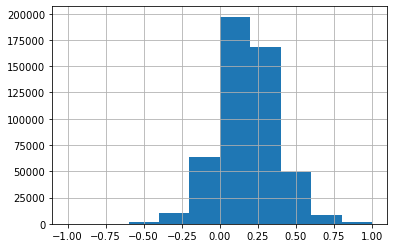

In [5]:
#add columns to dataframe
text_df["textblob_sen"] = round(sentiments, 6)
text_df["textblob_sen"].hist()

### Method 2: Vadar

In [6]:
vadar_analyzer = SentimentIntensityAnalyzer()
nltk.download('punkt')

#function that average vadar sentiment of review texts by sentence
def calculate_sentiment_scores(sentence):
    sentiment = vadar_analyzer.polarity_scores(sentence)['compound']
    return(sentiment)

def vadar_sentiment(row):
    rows = nltk.tokenize.sent_tokenize(row)
    sensum = 0
    for sentence in rows:
        sensum += calculate_sentiment_scores(sentence)
    sentiment = sensum/len(rows)
    return sentiment

start_time = time.time()
sentiments = text.apply(vadar_sentiment)
end_time = time.time()
print("--- %s minutes  ---" % ((end_time - start_time)/60))

[nltk_data] Downloading package punkt to /Users/Sheffin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


--- 9.977994179725647 minutes  ---


<AxesSubplot:>

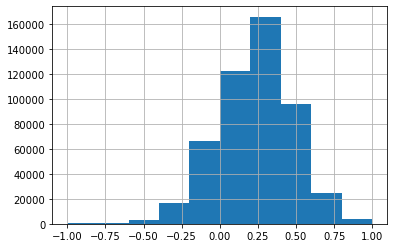

In [7]:
text_df["vadar_sen"] = round(sentiments, 6)
text_df["vadar_sen"].hist()

### Method 3: Flair

In [8]:
classifier = TextClassifier.load('en-sentiment')

def predict(sentence):
    if sentence == "":
        return 0
    text = Sentence(sentence)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.labels[0].to_dict()['confidence'] 
    else:
        result = -(text.labels[0].to_dict()['confidence'] )
    return round(result, 6)

#function that average flair sentiment of review texts by sentence
def flair_sentiment(row):
    rows = TextBlob(row)
    sensum = 0
    for sentence in rows.sentences:
        sensum += predict(sentence)
    sentiment = sensum/len(rows)
    return sentiment

# apply on the whole data
# start_time = time.time()
# sentiments = text.apply(flair_sentiment)
# end_time = time.time()
# print("--- %s minutes  ---" % ((end_time - start_time)/60))

2022-09-30 09:39:46,482 loading file /Users/Sheffin/.flair/models/sentiment-en-mix-distillbert_4.pt


In [9]:
# text_df["flair_sen"] = round(sentiments, 6)
# text_df["flair_sen"].hist()

## Calculate Subjectivity Scores

### Method 1: Textblob

In [31]:
#function that average subjectivity of review texts by sentence
def textblob_subjectivity(row):
    row = TextBlob(row)
    subsum = 0
    for sentence in row.sentences:
        subsum+=sentence.sentiment[1]
    subjectivity = subsum/len(row.sentences)
    return subjectivity

start_time = time.time()
subjectivity = text.apply(textblob_subjectivity)
end_time = time.time()
print("--- %s minutes  ---" % ((end_time - start_time)/60))

--- 9.686922613779704 minutes  ---


<AxesSubplot:>

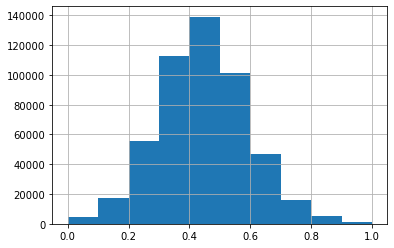

In [32]:
text_df["textblob_sub"] = round(subjectivity, 6)
text_df["textblob_sub"].hist()

## Calculate Readability Scores

### Method 1: Using textstat metric Flesch Reading Ease

In [33]:
#function to calculate flesch_reading_ease redability of text
def readability_func(row):
    readability = textstat.flesch_reading_ease(row)
    return readability

readability = text.apply(readability_func)

<AxesSubplot:>

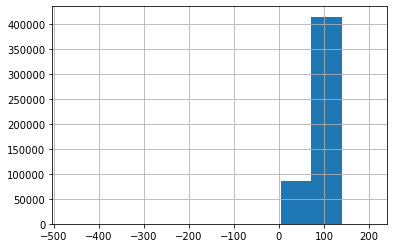

In [34]:
text_df["textstat_read"] = round(readability, 6)
text_df["textstat_read"].hist()

### Method 2: Using Readability metric Flesch Kincaid Grade

In [35]:
#function to calculate flesch_kincaid_grade redability of text
def readability_func(row):
    readability = textstat.flesch_kincaid_grade(row)
    return readability

readability = text.apply(readability_func)

<AxesSubplot:>

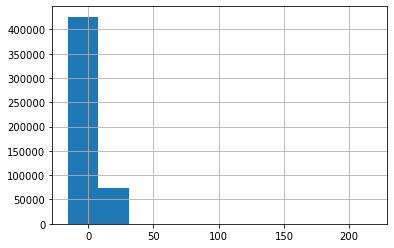

In [36]:
text_df["flesch_read"] = round(readability, 6)
text_df["flesch_read"].hist()

### Method 3: Using Readability metric Dale Chall Readability

In [37]:
#function to calculate dale_chall_readability_score redability of text
def readability_func(row):
    readability = textstat.dale_chall_readability_score(row)
    return readability

readability = text.apply(readability_func)

<AxesSubplot:>

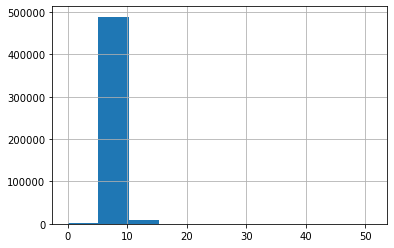

In [38]:
text_df["dale_read"] = round(readability, 6)
text_df["dale_read"].hist()

### Method 4: Using Readability metric Coleman Liau Index

In [39]:
#function to calculate coleman_liau_index redability of text
def readability_func(row):
    readability = textstat.coleman_liau_index(row)
    return readability

readability = text.apply(readability_func)

<AxesSubplot:>

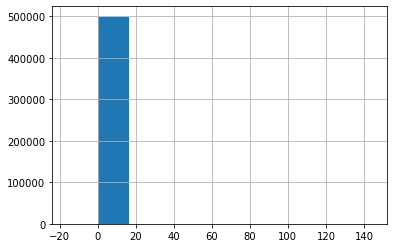

In [40]:
text_df["cli_read"] = round(readability, 6)
text_df["cli_read"].hist()

## Perform Linear Regression with Stochastic Gradient using train test split with StandardScaler on the Different Linguistic data calculations

In [41]:
#import data
df_trains = pd.read_parquet("/Users/Sheffin/Downloads/datas/train_main.parquet.snappy")
df_tests = pd.read_parquet("/Users/Sheffin/Downloads/datas/test_main.parquet.snappy")
#join the train and test sets
final_df = pd.concat([df_trains, df_tests], ignore_index=True)
final_df
#combine the calculated scores
Combined = pd.concat([final_df, text_df], axis=1, join='inner')
Combined.head()
Com

,r_id,r_stars,r_stars_square,r_length,u_friends_count,u_review_count,u_month_age,b_stars,b_review_count,r_sen,...,r_id,r_text,processed_txt,textblob_sen,vadar_sen,textblob_sub,textstat_read,flesch_read,dale_read,cli_read
0,1186481,1,1,99,146,360,4.715448,3.5,23,-0.015873,...,1186481,why why why why did the genuardi's near me hav...,why why why why did the genuardis near me have...,-0.015873,-0.175367,0.529586,85.99,3.9,6.96,6.30
1,2883679,5,25,275,1,4,32.377576,4.0,966,0.320463,...,2883679,My boyfriend and I went to Mai Lee today for a...,my boyfriend and i went to mai lee today for a...,0.320463,0.289172,0.549522,90.60,4.2,7.02,4.11
2,3878012,1,1,225,291,1,40.376371,3.5,300,-0.090963,...,3878012,I would give this place more stars if it wasn'...,i would give this place more stars if it wasnt...,-0.090963,-0.199145,0.533279,78.18,6.9,6.55,6.09
3,3590203,5,25,199,183,68,0.496642,4.0,449,0.217308,...,3590203,Two words: Hangover Brunch. I love 47 Scott fo...,two words hangover brunch. i love scott for ...,0.217308,0.327669,0.556899,82.14,5.4,8.39,7.82
4,3261255,5,25,35,1,2,39.044551,2.0,7,0.408333,...,3261255,Always a good experience. Dr Ramsey has been m...,always a good experience. dr ramsey has been m...,0.408333,0.347575,0.608333,79.46,4.4,7.23,4.67


In [79]:
Combined = Combined.drop(['r_id'], axis=1)
Combined.to_parquet("/Users/Sheffin/Downloads/data/Combined.parquet.snappy", index=False)

### Model 1 : Using textblob sentiment, textblob subjectivity and  flesch kincaid grade as the predictors

In [42]:
x1 = Combined[['textblob_sen','textblob_sub','flesch_read']]
y1 = Combined['r_useful']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=100000, random_state=760)

In [44]:
# standardise the features
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [45]:
random.seed(760)
sgd = SGDRegressor(max_iter=1000)
model = sgd.fit(X_train, y_train)

In [46]:
y_pred_train_sgd = sgd.predict(X_train)
y_pred_test_sgd  = sgd.predict(X_test)

print("Model 1: Using textblob sentiment, textblob subjectivity and  flesch kincaid grade as the predictors")
mae = mean_absolute_error(y_train, y_pred_train_sgd)
mse = mean_squared_error(y_train, y_pred_train_sgd)
rmse = np.sqrt(mse)
print("On training set: RMSE:", rmse, "MAE", mae)

#Prediction(test) 
mae = mean_absolute_error(y_test, y_pred_test_sgd)
mse = mean_squared_error(y_test, y_pred_test_sgd)
rmse = np.sqrt(mse)
print("On test set: RMSE:", rmse, "MAE", mae)

Model 1: Using textblob sentiment, textblob subjectivity and  flesch kincaid grade as the predictors
On training set: RMSE: 4.238814969076293 MAE 1.8687856896212531
On test set: RMSE: 4.006043527572095 MAE 1.8694450700719316


### Model 2 : Using vadar sentiment, textblob subjectivity and  dale chall readability as the predictors

In [47]:
x2 = Combined[['vadar_sen','textblob_sub','dale_read']]
y2 = Combined['r_useful']
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=100000, random_state=760)

# standardise the features
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

random.seed(760)
sgd = SGDRegressor(max_iter=1000)
model = sgd.fit(X_train, y_train)
y_pred_train_sgd = sgd.predict(X_train)
y_pred_test_sgd  = sgd.predict(X_test)

print("Model 2: Using vadar sentiment, textblob subjectivity and  dale chall readability as the predictors")
mae = mean_absolute_error(y_train, y_pred_train_sgd)
mse = mean_squared_error(y_train, y_pred_train_sgd)
rmse = np.sqrt(mse)
print("On training set: RMSE:", rmse, "MAE", mae)

#Prediction(test) 
mae = mean_absolute_error(y_test, y_pred_test_sgd)
mse = mean_squared_error(y_test, y_pred_test_sgd)
rmse = np.sqrt(mse)
print("On test set: RMSE:", rmse, "MAE", mae)

Model 2: Using vadar sentiment, textblob subjectivity and  dale chall readability as the predictors
On training set: RMSE: 4.247010349121353 MAE 1.8739054147407188
On test set: RMSE: 4.014342084288345 MAE 1.8742269013198865


### Model 3 : Using vadar sentiment, textblob subjectivity and coleman liau index as the predictors

In [48]:
x3 = Combined[['vadar_sen','textblob_sub','cli_read']]
y3 = Combined['r_useful']
X_train, X_test, y_train, y_test = train_test_split(x3, y3, test_size=100000, random_state=760)

# standardise the features
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

random.seed(760)
sgd = SGDRegressor(max_iter=1000)
model = sgd.fit(X_train, y_train)
y_pred_train_sgd = sgd.predict(X_train)
y_pred_test_sgd  = sgd.predict(X_test)

print("Model 3: Using vadar sentiment, textblob subjectivity and coleman liau index as the predictors")

mae = mean_absolute_error(y_train, y_pred_train_sgd)
mse = mean_squared_error(y_train, y_pred_train_sgd)
rmse = np.sqrt(mse)
print("On training set: RMSE:", rmse, "MAE", mae)

#Prediction(test) 
mae = mean_absolute_error(y_test, y_pred_test_sgd)
mse = mean_squared_error(y_test, y_pred_test_sgd)
rmse = np.sqrt(mse)
print("On test set: RMSE:", rmse, "MAE", mae)

Model 3: Using vadar sentiment, textblob subjectivity and coleman liau index as the predictors
On training set: RMSE: 4.242728849156708 MAE 1.9007006717172332
On test set: RMSE: 4.010229701618719 MAE 1.9011983299601645


### Model 4 : Using  vadar sentiment, textblob subjectivity and  flesch reading ease core as the predictors

In [49]:
x4 = Combined[['vadar_sen','textblob_sub','textstat_read']]
y4 = Combined['r_useful']
X_train, X_test, y_train, y_test = train_test_split(x4, y4, test_size=100000, random_state=760)

# standardise the features
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

random.seed(760)
sgd = SGDRegressor(max_iter=1000)
model = sgd.fit(X_train, y_train)
y_pred_train_sgd = sgd.predict(X_train)
y_pred_test_sgd  = sgd.predict(X_test)

print("Model 4: Using  vadar sentiment, textblob subjectivity and  flesch reading ease core as the predictors")

mae = mean_absolute_error(y_train, y_pred_train_sgd)
mse = mean_squared_error(y_train, y_pred_train_sgd)
rmse = np.sqrt(mse)
print("On training set: RMSE:", rmse, "MAE", mae)

#Prediction(test) 
mae = mean_absolute_error(y_test, y_pred_test_sgd)
mse = mean_squared_error(y_test, y_pred_test_sgd)
rmse = np.sqrt(mse)
print("On test set: RMSE:", rmse, "MAE", mae)

Model 4: Using  vadar sentiment, textblob subjectivity and  flesch reading ease core as the predictors
On training set: RMSE: 4.24133373941179 MAE 1.8684107467926303
On test set: RMSE: 4.008455781017183 MAE 1.868998629765549


## Perform Linear Regression with Stochastic Gradient using 3 fold CV with Optuna(50 trials) and StandardScaler on the Different Linguistic data calculation

### Model 1 : Using textblob sentiment, textblob subjectivity and  flesch kincaid grade as the predictors

In [53]:
x1 = Combined[['textblob_sen','textblob_sub','flesch_read']]
y1 = Combined['r_useful']

X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=100000, random_state=760)


def objective(trial):
    start = time.time()
    params = {
        "alpha": trial.suggest_float('alpha', 0.00001, 0.005),
        "eta0": trial.suggest_float('eta0', 0.005, 0.1),
        "power_t": trial.suggest_float('power_t', 0.1, 0.5),
        "learning_rate" : trial.suggest_categorical("learning_rate", ['constant', 'optimal', 'invscaling', 'adaptive']),
    }
    print("Currently running with:")
    print(params)
    
    model = SGDRegressor(**params)
    
    pipe = make_pipeline(StandardScaler(), model)

    cvscore = np.sqrt(-np.mean(cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv=3)))
    print("Time cost:", time.time()-start)
    return cvscore

In [54]:
sampler = TPESampler(seed=760)
study = opt.create_study(direction = 'minimize', sampler=sampler)
study.optimize(objective, n_trials = 50)
study.best_params

[I 2022-09-30 10:13:03,211] A new study created in memory with name: no-name-05e42711-1c27-46dc-a897-30330189db52


Currently running with:
{'alpha': 0.0006317184759975218, 'eta0': 0.016731546296316617, 'power_t': 0.1834729009323225, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:13:04,445] Trial 0 finished with value: 4.252121530844282 and parameters: {'alpha': 0.0006317184759975218, 'eta0': 0.016731546296316617, 'power_t': 0.1834729009323225, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 4.252121530844282.


Time cost: 1.2305848598480225
Currently running with:
{'alpha': 0.00467522094006339, 'eta0': 0.06686496039086667, 'power_t': 0.4613340702913661, 'learning_rate': 'optimal'}


[I 2022-09-30 10:13:05,317] Trial 1 finished with value: 4.2390781048927595 and parameters: {'alpha': 0.00467522094006339, 'eta0': 0.06686496039086667, 'power_t': 0.4613340702913661, 'learning_rate': 'optimal'}. Best is trial 1 with value: 4.2390781048927595.


Time cost: 0.8710536956787109
Currently running with:
{'alpha': 0.004992045087032479, 'eta0': 0.012721364135721626, 'power_t': 0.25191789543711485, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:13:06,554] Trial 2 finished with value: 4.255743088285452 and parameters: {'alpha': 0.004992045087032479, 'eta0': 0.012721364135721626, 'power_t': 0.25191789543711485, 'learning_rate': 'invscaling'}. Best is trial 1 with value: 4.2390781048927595.


Time cost: 1.2357549667358398
Currently running with:
{'alpha': 0.002604474326440665, 'eta0': 0.015963745402900933, 'power_t': 0.47478030732866006, 'learning_rate': 'optimal'}


[I 2022-09-30 10:13:07,672] Trial 3 finished with value: 4.238815773713763 and parameters: {'alpha': 0.002604474326440665, 'eta0': 0.015963745402900933, 'power_t': 0.47478030732866006, 'learning_rate': 'optimal'}. Best is trial 3 with value: 4.238815773713763.


Time cost: 1.117351770401001
Currently running with:
{'alpha': 0.0016544013731031797, 'eta0': 0.03511949023280408, 'power_t': 0.23364767209746207, 'learning_rate': 'optimal'}


[I 2022-09-30 10:13:08,929] Trial 4 finished with value: 4.241766904961157 and parameters: {'alpha': 0.0016544013731031797, 'eta0': 0.03511949023280408, 'power_t': 0.23364767209746207, 'learning_rate': 'optimal'}. Best is trial 3 with value: 4.238815773713763.


Time cost: 1.2561030387878418
Currently running with:
{'alpha': 0.002654514797011516, 'eta0': 0.04608651028371386, 'power_t': 0.3225456221546018, 'learning_rate': 'optimal'}


[I 2022-09-30 10:13:10,235] Trial 5 finished with value: 4.239629979404323 and parameters: {'alpha': 0.002654514797011516, 'eta0': 0.04608651028371386, 'power_t': 0.3225456221546018, 'learning_rate': 'optimal'}. Best is trial 3 with value: 4.238815773713763.


Time cost: 1.305079698562622
Currently running with:
{'alpha': 0.0014643704427594363, 'eta0': 0.08238504777433875, 'power_t': 0.2249314429228989, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:12,545] Trial 6 finished with value: 4.238553029309342 and parameters: {'alpha': 0.0014643704427594363, 'eta0': 0.08238504777433875, 'power_t': 0.2249314429228989, 'learning_rate': 'adaptive'}. Best is trial 6 with value: 4.238553029309342.


Time cost: 2.309299945831299
Currently running with:
{'alpha': 0.00480605447159026, 'eta0': 0.045352549383945465, 'power_t': 0.32118920579881605, 'learning_rate': 'constant'}


[I 2022-09-30 10:13:12,860] Trial 7 finished with value: 258009757.2460726 and parameters: {'alpha': 0.00480605447159026, 'eta0': 0.045352549383945465, 'power_t': 0.32118920579881605, 'learning_rate': 'constant'}. Best is trial 6 with value: 4.238553029309342.


Time cost: 0.3136577606201172
Currently running with:
{'alpha': 0.003612391397613086, 'eta0': 0.038759713403578616, 'power_t': 0.4321483873235922, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:14,734] Trial 8 finished with value: 4.238663572194047 and parameters: {'alpha': 0.003612391397613086, 'eta0': 0.038759713403578616, 'power_t': 0.4321483873235922, 'learning_rate': 'adaptive'}. Best is trial 6 with value: 4.238553029309342.


Time cost: 1.8733417987823486
Currently running with:
{'alpha': 0.0031038155377297455, 'eta0': 0.015362060456808737, 'power_t': 0.17392853466997585, 'learning_rate': 'optimal'}


[I 2022-09-30 10:13:15,906] Trial 9 finished with value: 4.23916929628958 and parameters: {'alpha': 0.0031038155377297455, 'eta0': 0.015362060456808737, 'power_t': 0.17392853466997585, 'learning_rate': 'optimal'}. Best is trial 6 with value: 4.238553029309342.


Time cost: 1.170888900756836
Currently running with:
{'alpha': 0.0006889602029425319, 'eta0': 0.09986462085704467, 'power_t': 0.1043674657292189, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:18,340] Trial 10 finished with value: 4.238548514568128 and parameters: {'alpha': 0.0006889602029425319, 'eta0': 0.09986462085704467, 'power_t': 0.1043674657292189, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.238548514568128.


Time cost: 2.433011054992676
Currently running with:
{'alpha': 0.0002218481067161218, 'eta0': 0.09327459248212842, 'power_t': 0.10523065171817737, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:20,653] Trial 11 finished with value: 4.238511774150945 and parameters: {'alpha': 0.0002218481067161218, 'eta0': 0.09327459248212842, 'power_t': 0.10523065171817737, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.3121678829193115
Currently running with:
{'alpha': 0.00010239696925696705, 'eta0': 0.09920003811496615, 'power_t': 0.10041802094780183, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:23,011] Trial 12 finished with value: 4.2385202545827285 and parameters: {'alpha': 0.00010239696925696705, 'eta0': 0.09920003811496615, 'power_t': 0.10041802094780183, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.357095956802368
Currently running with:
{'alpha': 0.00020665274406805252, 'eta0': 0.0991205241299288, 'power_t': 0.10281972920805396, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:25,354] Trial 13 finished with value: 4.238535915034056 and parameters: {'alpha': 0.00020665274406805252, 'eta0': 0.0991205241299288, 'power_t': 0.10281972920805396, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.3417458534240723
Currently running with:
{'alpha': 7.74553148987189e-05, 'eta0': 0.0807225283504536, 'power_t': 0.14906930242362074, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:27,456] Trial 14 finished with value: 4.238524655753004 and parameters: {'alpha': 7.74553148987189e-05, 'eta0': 0.0807225283504536, 'power_t': 0.14906930242362074, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.101062774658203
Currently running with:
{'alpha': 0.0014614594360169138, 'eta0': 0.08390155364902338, 'power_t': 0.40275264936820326, 'learning_rate': 'constant'}


[I 2022-09-30 10:13:27,812] Trial 15 finished with value: 2410626456835.918 and parameters: {'alpha': 0.0014614594360169138, 'eta0': 0.08390155364902338, 'power_t': 0.40275264936820326, 'learning_rate': 'constant'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 0.35571813583374023
Currently running with:
{'alpha': 0.0009343124308417027, 'eta0': 0.06522454886364701, 'power_t': 0.14210140337480343, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:29,939] Trial 16 finished with value: 4.238524760304834 and parameters: {'alpha': 0.0009343124308417027, 'eta0': 0.06522454886364701, 'power_t': 0.14210140337480343, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.1261723041534424
Currently running with:
{'alpha': 0.001969804725636582, 'eta0': 0.09012398655188571, 'power_t': 0.2774831750378573, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:32,161] Trial 17 finished with value: 4.238563766652106 and parameters: {'alpha': 0.001969804725636582, 'eta0': 0.09012398655188571, 'power_t': 0.2774831750378573, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.22038197517395
Currently running with:
{'alpha': 0.0008397636031155932, 'eta0': 0.06914354538935545, 'power_t': 0.3718997867208428, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:34,282] Trial 18 finished with value: 4.23852917118804 and parameters: {'alpha': 0.0008397636031155932, 'eta0': 0.06914354538935545, 'power_t': 0.3718997867208428, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.1201510429382324
Currently running with:
{'alpha': 4.482772819583373e-05, 'eta0': 0.059612517496141805, 'power_t': 0.20651594476490512, 'learning_rate': 'constant'}


[I 2022-09-30 10:13:34,719] Trial 19 finished with value: 1425338897768.936 and parameters: {'alpha': 4.482772819583373e-05, 'eta0': 0.059612517496141805, 'power_t': 0.20651594476490512, 'learning_rate': 'constant'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 0.4361090660095215
Currently running with:
{'alpha': 0.0020044950549989063, 'eta0': 0.07530131090818575, 'power_t': 0.13880338963965383, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:13:35,365] Trial 20 finished with value: 4.362444212743551 and parameters: {'alpha': 0.0020044950549989063, 'eta0': 0.07530131090818575, 'power_t': 0.13880338963965383, 'learning_rate': 'invscaling'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 0.6452548503875732
Currently running with:
{'alpha': 0.0002698388086075658, 'eta0': 0.09083911948544193, 'power_t': 0.14447195176369867, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:37,826] Trial 21 finished with value: 4.238544588896282 and parameters: {'alpha': 0.0002698388086075658, 'eta0': 0.09083911948544193, 'power_t': 0.14447195176369867, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.459707260131836
Currently running with:
{'alpha': 4.3736314770905565e-05, 'eta0': 0.07947484574721991, 'power_t': 0.10618757100073167, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:40,165] Trial 22 finished with value: 4.238526850637326 and parameters: {'alpha': 4.3736314770905565e-05, 'eta0': 0.07947484574721991, 'power_t': 0.10618757100073167, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.338660955429077
Currently running with:
{'alpha': 0.0010396667156448197, 'eta0': 0.0907752879978647, 'power_t': 0.17517028131782844, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:42,282] Trial 23 finished with value: 4.238579723723075 and parameters: {'alpha': 0.0010396667156448197, 'eta0': 0.0907752879978647, 'power_t': 0.17517028131782844, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.115115165710449
Currently running with:
{'alpha': 0.0004785976963212371, 'eta0': 0.09095596561154226, 'power_t': 0.1448098429768105, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:44,547] Trial 24 finished with value: 4.23854784766432 and parameters: {'alpha': 0.0004785976963212371, 'eta0': 0.09095596561154226, 'power_t': 0.1448098429768105, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.264902114868164
Currently running with:
{'alpha': 0.0010710382379957018, 'eta0': 0.09931552736275269, 'power_t': 0.12930707114397536, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:46,808] Trial 25 finished with value: 4.2385553198498345 and parameters: {'alpha': 0.0010710382379957018, 'eta0': 0.09931552736275269, 'power_t': 0.12930707114397536, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.260097026824951
Currently running with:
{'alpha': 0.00043100678707629574, 'eta0': 0.08621355351667381, 'power_t': 0.1945080272708573, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:49,377] Trial 26 finished with value: 4.2385210825965425 and parameters: {'alpha': 0.00043100678707629574, 'eta0': 0.08621355351667381, 'power_t': 0.1945080272708573, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.5674757957458496
Currently running with:
{'alpha': 0.00045788822758430133, 'eta0': 0.07300015799597395, 'power_t': 0.20226184837755787, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:51,558] Trial 27 finished with value: 4.238590941778353 and parameters: {'alpha': 0.00045788822758430133, 'eta0': 0.07300015799597395, 'power_t': 0.20226184837755787, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.180928945541382
Currently running with:
{'alpha': 0.0013704117409887, 'eta0': 0.08796297252406526, 'power_t': 0.2908395412544278, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:13:52,877] Trial 28 finished with value: 4.291225046665826 and parameters: {'alpha': 0.0013704117409887, 'eta0': 0.08796297252406526, 'power_t': 0.2908395412544278, 'learning_rate': 'invscaling'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 1.3174400329589844
Currently running with:
{'alpha': 0.0006845578784102362, 'eta0': 0.024379125385276954, 'power_t': 0.18860694912355883, 'learning_rate': 'constant'}


[I 2022-09-30 10:13:53,241] Trial 29 finished with value: 6.02118958617337 and parameters: {'alpha': 0.0006845578784102362, 'eta0': 0.024379125385276954, 'power_t': 0.18860694912355883, 'learning_rate': 'constant'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 0.3634531497955322
Currently running with:
{'alpha': 0.004069090910677207, 'eta0': 0.061233020913817784, 'power_t': 0.17804069838486442, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:13:54,195] Trial 30 finished with value: 4.275160632329284 and parameters: {'alpha': 0.004069090910677207, 'eta0': 0.061233020913817784, 'power_t': 0.17804069838486442, 'learning_rate': 'invscaling'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 0.9525411128997803
Currently running with:
{'alpha': 0.0003927070995602505, 'eta0': 0.07994309017450033, 'power_t': 0.1615380334905978, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:56,830] Trial 31 finished with value: 4.238528735848097 and parameters: {'alpha': 0.0003927070995602505, 'eta0': 0.07994309017450033, 'power_t': 0.1615380334905978, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.634054183959961
Currently running with:
{'alpha': 0.0005630343953664994, 'eta0': 0.09470174657381532, 'power_t': 0.11969170632633429, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:13:59,474] Trial 32 finished with value: 4.238521952872021 and parameters: {'alpha': 0.0005630343953664994, 'eta0': 0.09470174657381532, 'power_t': 0.11969170632633429, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.6434988975524902
Currently running with:
{'alpha': 0.0007499384109797952, 'eta0': 0.09744736431059894, 'power_t': 0.11863123668726575, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:01,813] Trial 33 finished with value: 4.238516723820166 and parameters: {'alpha': 0.0007499384109797952, 'eta0': 0.09744736431059894, 'power_t': 0.11863123668726575, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.3377082347869873
Currently running with:
{'alpha': 0.001044923188324325, 'eta0': 0.09581836522010091, 'power_t': 0.2557260098815657, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:04,107] Trial 34 finished with value: 4.238531727143759 and parameters: {'alpha': 0.001044923188324325, 'eta0': 0.09581836522010091, 'power_t': 0.2557260098815657, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.2934532165527344
Currently running with:
{'alpha': 0.001851513256185153, 'eta0': 0.08573235963649097, 'power_t': 0.12216840911151239, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:06,218] Trial 35 finished with value: 4.238566080090393 and parameters: {'alpha': 0.001851513256185153, 'eta0': 0.08573235963649097, 'power_t': 0.12216840911151239, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.109853982925415
Currently running with:
{'alpha': 0.0011652061132375303, 'eta0': 0.09517328750030363, 'power_t': 0.49853617209472745, 'learning_rate': 'optimal'}


[I 2022-09-30 10:14:07,534] Trial 36 finished with value: 4.250999329637989 and parameters: {'alpha': 0.0011652061132375303, 'eta0': 0.09517328750030363, 'power_t': 0.49853617209472745, 'learning_rate': 'optimal'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 1.3149292469024658
Currently running with:
{'alpha': 0.0022190248547293073, 'eta0': 0.07559949410485416, 'power_t': 0.2216443704688905, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:14:08,656] Trial 37 finished with value: 4.280489477779869 and parameters: {'alpha': 0.0022190248547293073, 'eta0': 0.07559949410485416, 'power_t': 0.2216443704688905, 'learning_rate': 'invscaling'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 1.121551752090454
Currently running with:
{'alpha': 0.0003730843970927794, 'eta0': 0.024627364301017828, 'power_t': 0.10043731290135775, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:10,430] Trial 38 finished with value: 4.238512199490467 and parameters: {'alpha': 0.0003730843970927794, 'eta0': 0.024627364301017828, 'power_t': 0.10043731290135775, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 1.7731120586395264
Currently running with:
{'alpha': 0.0006938664979393449, 'eta0': 0.006587198729841669, 'power_t': 0.11828619855791331, 'learning_rate': 'optimal'}


[I 2022-09-30 10:14:12,434] Trial 39 finished with value: 4.2406868721672115 and parameters: {'alpha': 0.0006938664979393449, 'eta0': 0.006587198729841669, 'power_t': 0.11828619855791331, 'learning_rate': 'optimal'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.0026402473449707
Currently running with:
{'alpha': 0.003165259218737412, 'eta0': 0.024452269853633756, 'power_t': 0.10002355713028793, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:14,639] Trial 40 finished with value: 4.238623801591396 and parameters: {'alpha': 0.003165259218737412, 'eta0': 0.024452269853633756, 'power_t': 0.10002355713028793, 'learning_rate': 'adaptive'}. Best is trial 11 with value: 4.238511774150945.


Time cost: 2.203958034515381
Currently running with:
{'alpha': 0.0003376165592969258, 'eta0': 0.05159160728340707, 'power_t': 0.1597499986096588, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:16,872] Trial 41 finished with value: 4.2385058445397705 and parameters: {'alpha': 0.0003376165592969258, 'eta0': 0.05159160728340707, 'power_t': 0.1597499986096588, 'learning_rate': 'adaptive'}. Best is trial 41 with value: 4.2385058445397705.


Time cost: 2.232550859451294
Currently running with:
{'alpha': 0.0002919400406640247, 'eta0': 0.05382352055863533, 'power_t': 0.1596240001045388, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:18,978] Trial 42 finished with value: 4.238548467739643 and parameters: {'alpha': 0.0002919400406640247, 'eta0': 0.05382352055863533, 'power_t': 0.1596240001045388, 'learning_rate': 'adaptive'}. Best is trial 41 with value: 4.2385058445397705.


Time cost: 2.104437828063965
Currently running with:
{'alpha': 0.0007783672933524914, 'eta0': 0.03379049038181645, 'power_t': 0.12747117784641182, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:21,230] Trial 43 finished with value: 4.2385606682958175 and parameters: {'alpha': 0.0007783672933524914, 'eta0': 0.03379049038181645, 'power_t': 0.12747117784641182, 'learning_rate': 'adaptive'}. Best is trial 41 with value: 4.2385058445397705.


Time cost: 2.2517759799957275
Currently running with:
{'alpha': 2.2043559748921224e-05, 'eta0': 0.04285419999478496, 'power_t': 0.15960119496703395, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:23,395] Trial 44 finished with value: 4.238522378452835 and parameters: {'alpha': 2.2043559748921224e-05, 'eta0': 0.04285419999478496, 'power_t': 0.15960119496703395, 'learning_rate': 'adaptive'}. Best is trial 41 with value: 4.2385058445397705.


Time cost: 2.1640090942382812
Currently running with:
{'alpha': 0.0013337107162478903, 'eta0': 0.05019093051978759, 'power_t': 0.11630449571874225, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:25,726] Trial 45 finished with value: 4.238532004275507 and parameters: {'alpha': 0.0013337107162478903, 'eta0': 0.05019093051978759, 'power_t': 0.11630449571874225, 'learning_rate': 'adaptive'}. Best is trial 41 with value: 4.2385058445397705.


Time cost: 2.329519033432007
Currently running with:
{'alpha': 0.0001790496438089963, 'eta0': 0.02692603641864455, 'power_t': 0.10007449937920009, 'learning_rate': 'constant'}


[I 2022-09-30 10:14:26,127] Trial 46 finished with value: 4.633533797067136 and parameters: {'alpha': 0.0001790496438089963, 'eta0': 0.02692603641864455, 'power_t': 0.10007449937920009, 'learning_rate': 'constant'}. Best is trial 41 with value: 4.2385058445397705.


Time cost: 0.40106701850891113
Currently running with:
{'alpha': 0.0006234046541919358, 'eta0': 0.0299080259024003, 'power_t': 0.3508206179567087, 'learning_rate': 'optimal'}


[I 2022-09-30 10:14:27,807] Trial 47 finished with value: 4.2407375688506495 and parameters: {'alpha': 0.0006234046541919358, 'eta0': 0.0299080259024003, 'power_t': 0.3508206179567087, 'learning_rate': 'optimal'}. Best is trial 41 with value: 4.2385058445397705.


Time cost: 1.6790120601654053
Currently running with:
{'alpha': 0.0003319821357550158, 'eta0': 0.01838005291320272, 'power_t': 0.16337712760276124, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:29,749] Trial 48 finished with value: 4.238533448380285 and parameters: {'alpha': 0.0003319821357550158, 'eta0': 0.01838005291320272, 'power_t': 0.16337712760276124, 'learning_rate': 'adaptive'}. Best is trial 41 with value: 4.2385058445397705.


Time cost: 1.9408328533172607
Currently running with:
{'alpha': 0.0008642026597668542, 'eta0': 0.037894424812009365, 'power_t': 0.13470951916262305, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:14:32,112] Trial 49 finished with value: 4.238530054735457 and parameters: {'alpha': 0.0008642026597668542, 'eta0': 0.037894424812009365, 'power_t': 0.13470951916262305, 'learning_rate': 'adaptive'}. Best is trial 41 with value: 4.2385058445397705.


Time cost: 2.3617899417877197


{'alpha': 0.0003376165592969258,
 'eta0': 0.05159160728340707,
 'power_t': 0.1597499986096588,
 'learning_rate': 'adaptive'}

In [55]:
model = SGDRegressor(alpha = 0.0003376165592969258,
                   eta0 = 0.05159160728340707, 
                   power_t = 0.1597499986096588,
                   learning_rate =  'adaptive')
pipe = make_pipeline(StandardScaler(), model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0003376165592969258,
                              eta0=0.05159160728340707,
                              learning_rate='adaptive',
                              power_t=0.1597499986096588))])

In [56]:
y_pred_train_sgd = pipe.predict(X_train)
y_pred_test_sgd  = pipe.predict(X_test)

print("Model 1 cv: Using textblob sentiment, textblob subjectivity and  flesch kincaid grade as the predictors")

mae = mean_absolute_error(y_train, y_pred_train_sgd)
mse = mean_squared_error(y_train, y_pred_train_sgd)
rmse = np.sqrt(mse)
print("On training set: RMSE:", rmse, "MAE", mae)

#Prediction(test) 
mae = mean_absolute_error(y_test, y_pred_test_sgd)
mse = mean_squared_error(y_test, y_pred_test_sgd)
rmse = np.sqrt(mse)
print("On test set: RMSE:", rmse, "MAE", mae)

Model 1 cv: Using textblob sentiment, textblob subjectivity and  flesch kincaid grade as the predictors
On training set: RMSE: 4.23846859041707 MAE 1.855714084098368
On test set: RMSE: 4.005822421764906 MAE 1.8564658245289016


### Model 2 : Using vadar sentiment, textblob subjectivity and  dale chall readability as the predictors

In [57]:
x2 = Combined[['vadar_sen','textblob_sub','dale_read']]
y2 = Combined['r_useful']

X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size=100000, random_state=760)


def objective(trial):
    start = time.time()
    params = {
        "alpha": trial.suggest_float('alpha', 0.00001, 0.005),
        "eta0": trial.suggest_float('eta0', 0.005, 0.1),
        "power_t": trial.suggest_float('power_t', 0.1, 0.5),
        "learning_rate" : trial.suggest_categorical("learning_rate", ['constant', 'optimal', 'invscaling', 'adaptive']),
    }
    print("Currently running with:")
    print(params)
    
    model = SGDRegressor(**params)
    
    pipe = make_pipeline(StandardScaler(), model)

    cvscore = np.sqrt(-np.mean(cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv=3)))
    print("Time cost:", time.time()-start)
    return cvscore

study = opt.create_study(direction = 'minimize', sampler=sampler)
study.optimize(objective, n_trials = 50)
study.best_params

[I 2022-09-30 10:16:12,959] A new study created in memory with name: no-name-6583fd23-187d-4fac-a306-1fdf8793bb79


Currently running with:
{'alpha': 0.004608508142689348, 'eta0': 0.052220199399839955, 'power_t': 0.20600975070987948, 'learning_rate': 'optimal'}


[I 2022-09-30 10:16:16,602] Trial 0 finished with value: 4.248343255221943 and parameters: {'alpha': 0.004608508142689348, 'eta0': 0.052220199399839955, 'power_t': 0.20600975070987948, 'learning_rate': 'optimal'}. Best is trial 0 with value: 4.248343255221943.


Time cost: 3.6417479515075684
Currently running with:
{'alpha': 0.004993459771716508, 'eta0': 0.09657052506960578, 'power_t': 0.26074821861049335, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:18,817] Trial 1 finished with value: 4.246072839030931 and parameters: {'alpha': 0.004993459771716508, 'eta0': 0.09657052506960578, 'power_t': 0.26074821861049335, 'learning_rate': 'adaptive'}. Best is trial 1 with value: 4.246072839030931.


Time cost: 2.2133939266204834
Currently running with:
{'alpha': 0.003379696980621223, 'eta0': 0.08371285668217596, 'power_t': 0.21666967612591287, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:21,003] Trial 2 finished with value: 4.2459398896284295 and parameters: {'alpha': 0.003379696980621223, 'eta0': 0.08371285668217596, 'power_t': 0.21666967612591287, 'learning_rate': 'adaptive'}. Best is trial 2 with value: 4.2459398896284295.


Time cost: 2.185030937194824
Currently running with:
{'alpha': 0.0005995932776951025, 'eta0': 0.03780922890672172, 'power_t': 0.4232084182939514, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:16:22,164] Trial 3 finished with value: 4.255606659631263 and parameters: {'alpha': 0.0005995932776951025, 'eta0': 0.03780922890672172, 'power_t': 0.4232084182939514, 'learning_rate': 'invscaling'}. Best is trial 2 with value: 4.2459398896284295.


Time cost: 1.1599888801574707
Currently running with:
{'alpha': 7.762967219259538e-05, 'eta0': 0.04482673427923434, 'power_t': 0.241585438014065, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:16:24,813] Trial 4 finished with value: 4.278886029700335 and parameters: {'alpha': 7.762967219259538e-05, 'eta0': 0.04482673427923434, 'power_t': 0.241585438014065, 'learning_rate': 'invscaling'}. Best is trial 2 with value: 4.2459398896284295.


Time cost: 2.6487109661102295
Currently running with:
{'alpha': 0.0010967105297085059, 'eta0': 0.06842559837879278, 'power_t': 0.2911601460415567, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:16:27,921] Trial 5 finished with value: 4.321648851216136 and parameters: {'alpha': 0.0010967105297085059, 'eta0': 0.06842559837879278, 'power_t': 0.2911601460415567, 'learning_rate': 'invscaling'}. Best is trial 2 with value: 4.2459398896284295.


Time cost: 3.1074469089508057
Currently running with:
{'alpha': 0.0008005495047804054, 'eta0': 0.027993134923593017, 'power_t': 0.11182305969998399, 'learning_rate': 'constant'}


[I 2022-09-30 10:16:28,306] Trial 6 finished with value: 13.10712428347579 and parameters: {'alpha': 0.0008005495047804054, 'eta0': 0.027993134923593017, 'power_t': 0.11182305969998399, 'learning_rate': 'constant'}. Best is trial 2 with value: 4.2459398896284295.


Time cost: 0.3837089538574219
Currently running with:
{'alpha': 4.445924501230293e-05, 'eta0': 0.07627179303735553, 'power_t': 0.1995392284729976, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:30,688] Trial 7 finished with value: 4.245891848444835 and parameters: {'alpha': 4.445924501230293e-05, 'eta0': 0.07627179303735553, 'power_t': 0.1995392284729976, 'learning_rate': 'adaptive'}. Best is trial 7 with value: 4.245891848444835.


Time cost: 2.3815410137176514
Currently running with:
{'alpha': 0.0034067041762066274, 'eta0': 0.005956269093127419, 'power_t': 0.21638794038815565, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:32,659] Trial 8 finished with value: 4.245967915889787 and parameters: {'alpha': 0.0034067041762066274, 'eta0': 0.005956269093127419, 'power_t': 0.21638794038815565, 'learning_rate': 'adaptive'}. Best is trial 7 with value: 4.245891848444835.


Time cost: 1.9699032306671143
Currently running with:
{'alpha': 0.004620510879190266, 'eta0': 0.09423726579789887, 'power_t': 0.3940573129021778, 'learning_rate': 'constant'}


[I 2022-09-30 10:16:33,168] Trial 9 finished with value: 3129022396947.0845 and parameters: {'alpha': 0.004620510879190266, 'eta0': 0.09423726579789887, 'power_t': 0.3940573129021778, 'learning_rate': 'constant'}. Best is trial 7 with value: 4.245891848444835.


Time cost: 0.5079171657562256
Currently running with:
{'alpha': 0.002071088402270237, 'eta0': 0.06958989673991672, 'power_t': 0.10973854113136006, 'learning_rate': 'optimal'}


[I 2022-09-30 10:16:34,566] Trial 10 finished with value: 4.247308849862527 and parameters: {'alpha': 0.002071088402270237, 'eta0': 0.06958989673991672, 'power_t': 0.10973854113136006, 'learning_rate': 'optimal'}. Best is trial 7 with value: 4.245891848444835.


Time cost: 1.397200107574463
Currently running with:
{'alpha': 0.0030182291290288244, 'eta0': 0.07753939510345775, 'power_t': 0.1665285673885197, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:36,703] Trial 11 finished with value: 4.246085152921667 and parameters: {'alpha': 0.0030182291290288244, 'eta0': 0.07753939510345775, 'power_t': 0.1665285673885197, 'learning_rate': 'adaptive'}. Best is trial 7 with value: 4.245891848444835.


Time cost: 2.1357030868530273
Currently running with:
{'alpha': 0.0017010387013842855, 'eta0': 0.08273977622093252, 'power_t': 0.3163823385264433, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:39,575] Trial 12 finished with value: 4.245887823474028 and parameters: {'alpha': 0.0017010387013842855, 'eta0': 0.08273977622093252, 'power_t': 0.3163823385264433, 'learning_rate': 'adaptive'}. Best is trial 12 with value: 4.245887823474028.


Time cost: 2.8717360496520996
Currently running with:
{'alpha': 0.0018939628935203347, 'eta0': 0.06536789728663926, 'power_t': 0.36343113751932105, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:41,862] Trial 13 finished with value: 4.245948430611702 and parameters: {'alpha': 0.0018939628935203347, 'eta0': 0.06536789728663926, 'power_t': 0.36343113751932105, 'learning_rate': 'adaptive'}. Best is trial 12 with value: 4.245887823474028.


Time cost: 2.2858970165252686
Currently running with:
{'alpha': 0.0014372590942498707, 'eta0': 0.08212444717248672, 'power_t': 0.3370775304280509, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:44,055] Trial 14 finished with value: 4.245890334955486 and parameters: {'alpha': 0.0014372590942498707, 'eta0': 0.08212444717248672, 'power_t': 0.3370775304280509, 'learning_rate': 'adaptive'}. Best is trial 12 with value: 4.245887823474028.


Time cost: 2.191420793533325
Currently running with:
{'alpha': 0.001596115290489231, 'eta0': 0.08784526708973531, 'power_t': 0.4962460966835823, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:46,755] Trial 15 finished with value: 4.245913142533843 and parameters: {'alpha': 0.001596115290489231, 'eta0': 0.08784526708973531, 'power_t': 0.4962460966835823, 'learning_rate': 'adaptive'}. Best is trial 12 with value: 4.245887823474028.


Time cost: 2.6991679668426514
Currently running with:
{'alpha': 0.0025245821420451066, 'eta0': 0.05866773639401476, 'power_t': 0.3417360806952273, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:48,918] Trial 16 finished with value: 4.245896345342373 and parameters: {'alpha': 0.0025245821420451066, 'eta0': 0.05866773639401476, 'power_t': 0.3417360806952273, 'learning_rate': 'adaptive'}. Best is trial 12 with value: 4.245887823474028.


Time cost: 2.162174940109253
Currently running with:
{'alpha': 0.0013845004373507165, 'eta0': 0.09907141828748818, 'power_t': 0.3191107161426863, 'learning_rate': 'constant'}


[I 2022-09-30 10:16:49,357] Trial 17 finished with value: 4756800625210.717 and parameters: {'alpha': 0.0013845004373507165, 'eta0': 0.09907141828748818, 'power_t': 0.3191107161426863, 'learning_rate': 'constant'}. Best is trial 12 with value: 4.245887823474028.


Time cost: 0.43846917152404785
Currently running with:
{'alpha': 0.002320841916030228, 'eta0': 0.08444644332913502, 'power_t': 0.44215903774007403, 'learning_rate': 'optimal'}


[I 2022-09-30 10:16:50,432] Trial 18 finished with value: 4.246677389494359 and parameters: {'alpha': 0.002320841916030228, 'eta0': 0.08444644332913502, 'power_t': 0.44215903774007403, 'learning_rate': 'optimal'}. Best is trial 12 with value: 4.245887823474028.


Time cost: 1.0741240978240967
Currently running with:
{'alpha': 0.002724811636835439, 'eta0': 0.022674327766161566, 'power_t': 0.29930020289904063, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:52,270] Trial 19 finished with value: 4.245940103419646 and parameters: {'alpha': 0.002724811636835439, 'eta0': 0.022674327766161566, 'power_t': 0.29930020289904063, 'learning_rate': 'adaptive'}. Best is trial 12 with value: 4.245887823474028.


Time cost: 1.8366150856018066
Currently running with:
{'alpha': 0.0015996094878164828, 'eta0': 0.054468464530488564, 'power_t': 0.364415195159083, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:54,213] Trial 20 finished with value: 4.245870088368834 and parameters: {'alpha': 0.0015996094878164828, 'eta0': 0.054468464530488564, 'power_t': 0.364415195159083, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 1.9427571296691895
Currently running with:
{'alpha': 0.0015572555832732429, 'eta0': 0.06014840767414801, 'power_t': 0.3729578669287224, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:56,407] Trial 21 finished with value: 4.245962235102539 and parameters: {'alpha': 0.0015572555832732429, 'eta0': 0.06014840767414801, 'power_t': 0.3729578669287224, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 2.1928529739379883
Currently running with:
{'alpha': 0.001038463312258361, 'eta0': 0.07506513207653102, 'power_t': 0.32972406733580084, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:16:58,600] Trial 22 finished with value: 4.246042561861542 and parameters: {'alpha': 0.001038463312258361, 'eta0': 0.07506513207653102, 'power_t': 0.32972406733580084, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 2.191725969314575
Currently running with:
{'alpha': 0.0019007907029419016, 'eta0': 0.050950116607739224, 'power_t': 0.4075371766255181, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:01,038] Trial 23 finished with value: 4.2458866456057525 and parameters: {'alpha': 0.0019007907029419016, 'eta0': 0.050950116607739224, 'power_t': 0.4075371766255181, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 2.4374001026153564
Currently running with:
{'alpha': 0.0019143613856234599, 'eta0': 0.0381532250051967, 'power_t': 0.45424464557975064, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:03,349] Trial 24 finished with value: 4.245912130108321 and parameters: {'alpha': 0.0019143613856234599, 'eta0': 0.0381532250051967, 'power_t': 0.45424464557975064, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 2.3093698024749756
Currently running with:
{'alpha': 0.0004971753388994819, 'eta0': 0.05006035548885284, 'power_t': 0.3976037025491553, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:05,347] Trial 25 finished with value: 4.24589284419592 and parameters: {'alpha': 0.0004971753388994819, 'eta0': 0.05006035548885284, 'power_t': 0.3976037025491553, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 1.997467041015625
Currently running with:
{'alpha': 0.002212160210676551, 'eta0': 0.026218756605028294, 'power_t': 0.47325804940631494, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:17:06,379] Trial 26 finished with value: 4.247973803806388 and parameters: {'alpha': 0.002212160210676551, 'eta0': 0.026218756605028294, 'power_t': 0.47325804940631494, 'learning_rate': 'invscaling'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 1.0308952331542969
Currently running with:
{'alpha': 0.0028216957932869265, 'eta0': 0.039609767624098666, 'power_t': 0.404972170751761, 'learning_rate': 'optimal'}


[I 2022-09-30 10:17:07,788] Trial 27 finished with value: 4.24697569308832 and parameters: {'alpha': 0.0028216957932869265, 'eta0': 0.039609767624098666, 'power_t': 0.404972170751761, 'learning_rate': 'optimal'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 1.4084460735321045
Currently running with:
{'alpha': 0.0018023569591672384, 'eta0': 0.058907043583697714, 'power_t': 0.2748444521530473, 'learning_rate': 'constant'}


[I 2022-09-30 10:17:08,180] Trial 28 finished with value: 2209831693564.1284 and parameters: {'alpha': 0.0018023569591672384, 'eta0': 0.058907043583697714, 'power_t': 0.2748444521530473, 'learning_rate': 'constant'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 0.39116787910461426
Currently running with:
{'alpha': 0.0012311358819261002, 'eta0': 0.04921922253312868, 'power_t': 0.37007777053096563, 'learning_rate': 'optimal'}


[I 2022-09-30 10:17:09,908] Trial 29 finished with value: 4.2488422278145235 and parameters: {'alpha': 0.0012311358819261002, 'eta0': 0.04921922253312868, 'power_t': 0.37007777053096563, 'learning_rate': 'optimal'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 1.7270572185516357
Currently running with:
{'alpha': 0.003933784472556227, 'eta0': 0.05422479533059443, 'power_t': 0.431648626364098, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:12,173] Trial 30 finished with value: 4.245977047890333 and parameters: {'alpha': 0.003933784472556227, 'eta0': 0.05422479533059443, 'power_t': 0.431648626364098, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 2.263911247253418
Currently running with:
{'alpha': 0.0015351476135428118, 'eta0': 0.08953122800418212, 'power_t': 0.34511385062416267, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:14,737] Trial 31 finished with value: 4.245923095556693 and parameters: {'alpha': 0.0015351476135428118, 'eta0': 0.08953122800418212, 'power_t': 0.34511385062416267, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 2.5636560916900635
Currently running with:
{'alpha': 0.0009040133161427324, 'eta0': 0.07890974379170244, 'power_t': 0.31471761672554227, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:17,246] Trial 32 finished with value: 4.245873329784099 and parameters: {'alpha': 0.0009040133161427324, 'eta0': 0.07890974379170244, 'power_t': 0.31471761672554227, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 2.5076160430908203
Currently running with:
{'alpha': 0.0007999004278044699, 'eta0': 0.06635400702580363, 'power_t': 0.30690384378472707, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:19,460] Trial 33 finished with value: 4.245881049274451 and parameters: {'alpha': 0.0007999004278044699, 'eta0': 0.06635400702580363, 'power_t': 0.30690384378472707, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 2.2133820056915283
Currently running with:
{'alpha': 0.0004245770091323846, 'eta0': 0.06685246113031966, 'power_t': 0.2649315082191621, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:21,536] Trial 34 finished with value: 4.245906275031419 and parameters: {'alpha': 0.0004245770091323846, 'eta0': 0.06685246113031966, 'power_t': 0.2649315082191621, 'learning_rate': 'adaptive'}. Best is trial 20 with value: 4.245870088368834.


Time cost: 2.074599266052246
Currently running with:
{'alpha': 0.0008476118953695496, 'eta0': 0.04295208979989636, 'power_t': 0.24920540362378485, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:24,010] Trial 35 finished with value: 4.245859061625902 and parameters: {'alpha': 0.0008476118953695496, 'eta0': 0.04295208979989636, 'power_t': 0.24920540362378485, 'learning_rate': 'adaptive'}. Best is trial 35 with value: 4.245859061625902.


Time cost: 2.473177671432495
Currently running with:
{'alpha': 0.001004271328382327, 'eta0': 0.03283705495086561, 'power_t': 0.2432976882362153, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:17:26,882] Trial 36 finished with value: 4.275421767265755 and parameters: {'alpha': 0.001004271328382327, 'eta0': 0.03283705495086561, 'power_t': 0.2432976882362153, 'learning_rate': 'invscaling'}. Best is trial 35 with value: 4.245859061625902.


Time cost: 2.8714160919189453
Currently running with:
{'alpha': 0.0008024641578984752, 'eta0': 0.04433455655613365, 'power_t': 0.28794831507696844, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:29,515] Trial 37 finished with value: 4.245901545914108 and parameters: {'alpha': 0.0008024641578984752, 'eta0': 0.04433455655613365, 'power_t': 0.28794831507696844, 'learning_rate': 'adaptive'}. Best is trial 35 with value: 4.245859061625902.


Time cost: 2.6316721439361572
Currently running with:
{'alpha': 0.0007467437400947868, 'eta0': 0.061867141559870345, 'power_t': 0.247545852137556, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:31,619] Trial 38 finished with value: 4.24585661209652 and parameters: {'alpha': 0.0007467437400947868, 'eta0': 0.061867141559870345, 'power_t': 0.247545852137556, 'learning_rate': 'adaptive'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 2.103100061416626
Currently running with:
{'alpha': 0.00037559952330204314, 'eta0': 0.017320501083084104, 'power_t': 0.17471140571215343, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:17:34,116] Trial 39 finished with value: 4.262370631291231 and parameters: {'alpha': 0.00037559952330204314, 'eta0': 0.017320501083084104, 'power_t': 0.17471140571215343, 'learning_rate': 'invscaling'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 2.49595308303833
Currently running with:
{'alpha': 0.0002376523939046965, 'eta0': 0.04453346825465232, 'power_t': 0.24313302057214747, 'learning_rate': 'constant'}


[I 2022-09-30 10:17:34,429] Trial 40 finished with value: 600528017270.15 and parameters: {'alpha': 0.0002376523939046965, 'eta0': 0.04453346825465232, 'power_t': 0.24313302057214747, 'learning_rate': 'constant'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 0.31211209297180176
Currently running with:
{'alpha': 0.0007162206029091248, 'eta0': 0.0629600886882571, 'power_t': 0.19457808421395484, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:36,272] Trial 41 finished with value: 4.245901554194741 and parameters: {'alpha': 0.0007162206029091248, 'eta0': 0.0629600886882571, 'power_t': 0.19457808421395484, 'learning_rate': 'adaptive'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 1.8417198657989502
Currently running with:
{'alpha': 0.0009101035103313332, 'eta0': 0.0708518529077763, 'power_t': 0.22705527189945118, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:38,947] Trial 42 finished with value: 4.245870684132849 and parameters: {'alpha': 0.0009101035103313332, 'eta0': 0.0708518529077763, 'power_t': 0.22705527189945118, 'learning_rate': 'adaptive'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 2.6745190620422363
Currently running with:
{'alpha': 0.0011417477908762315, 'eta0': 0.07188906749343238, 'power_t': 0.23003761524982916, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:41,509] Trial 43 finished with value: 4.245867570222525 and parameters: {'alpha': 0.0011417477908762315, 'eta0': 0.07188906749343238, 'power_t': 0.23003761524982916, 'learning_rate': 'adaptive'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 2.5609169006347656
Currently running with:
{'alpha': 0.0011638170681997737, 'eta0': 0.055716934116764656, 'power_t': 0.22424412419642606, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:43,420] Trial 44 finished with value: 4.245940644450915 and parameters: {'alpha': 0.0011638170681997737, 'eta0': 0.055716934116764656, 'power_t': 0.22424412419642606, 'learning_rate': 'adaptive'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 1.9103889465332031
Currently running with:
{'alpha': 0.0005805806897174317, 'eta0': 0.07273417190005668, 'power_t': 0.14713844208068205, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:45,844] Trial 45 finished with value: 4.245970877168469 and parameters: {'alpha': 0.0005805806897174317, 'eta0': 0.07273417190005668, 'power_t': 0.14713844208068205, 'learning_rate': 'adaptive'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 2.4225451946258545
Currently running with:
{'alpha': 0.0012661694260813021, 'eta0': 0.07263401967469348, 'power_t': 0.22658809080910894, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:47,881] Trial 46 finished with value: 4.24595000308637 and parameters: {'alpha': 0.0012661694260813021, 'eta0': 0.07263401967469348, 'power_t': 0.22658809080910894, 'learning_rate': 'adaptive'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 2.036228895187378
Currently running with:
{'alpha': 0.0010499928057490322, 'eta0': 0.06302975613657186, 'power_t': 0.25731534712850673, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:50,033] Trial 47 finished with value: 4.245896312063651 and parameters: {'alpha': 0.0010499928057490322, 'eta0': 0.06302975613657186, 'power_t': 0.25731534712850673, 'learning_rate': 'adaptive'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 2.1516079902648926
Currently running with:
{'alpha': 1.395150487773218e-05, 'eta0': 0.06959169250593844, 'power_t': 0.20055792540665984, 'learning_rate': 'optimal'}


[I 2022-09-30 10:17:57,451] Trial 48 finished with value: 4.761550401683372 and parameters: {'alpha': 1.395150487773218e-05, 'eta0': 0.06959169250593844, 'power_t': 0.20055792540665984, 'learning_rate': 'optimal'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 7.416779041290283
Currently running with:
{'alpha': 0.000343569862504968, 'eta0': 0.03416987423689989, 'power_t': 0.2785149089093121, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:17:59,303] Trial 49 finished with value: 4.245886552174928 and parameters: {'alpha': 0.000343569862504968, 'eta0': 0.03416987423689989, 'power_t': 0.2785149089093121, 'learning_rate': 'adaptive'}. Best is trial 38 with value: 4.24585661209652.


Time cost: 1.8514690399169922


{'alpha': 0.0007467437400947868,
 'eta0': 0.061867141559870345,
 'power_t': 0.247545852137556,
 'learning_rate': 'adaptive'}

In [58]:
model = SGDRegressor(alpha = 0.0007467437400947868,
                   eta0 = 0.061867141559870345, 
                   power_t = 0.247545852137556,
                   learning_rate =  'adaptive')
pipe = make_pipeline(StandardScaler(), model)
pipe.fit(X_train, y_train)

y_pred_train_sgd = pipe.predict(X_train)
y_pred_test_sgd  = pipe.predict(X_test)

print("Model 2 cv: Using vadar sentiment, textblob subjectivity and  dale chall readability as the predictors")

mae = mean_absolute_error(y_train, y_pred_train_sgd)
mse = mean_squared_error(y_train, y_pred_train_sgd)
rmse = np.sqrt(mse)
print("On training set: RMSE:", rmse, "MAE", mae)

#Prediction(test) 
mae = mean_absolute_error(y_test, y_pred_test_sgd)
mse = mean_squared_error(y_test, y_pred_test_sgd)
rmse = np.sqrt(mse)
print("On test set: RMSE:", rmse, "MAE", mae)

Model 2 cv: Using vadar sentiment, textblob subjectivity and  dale chall readability as the predictors
On training set: RMSE: 4.245823851148902 MAE 1.8681389045603687
On test set: RMSE: 4.012883682149471 MAE 1.8682421023753004


### Model 3 : Using vadar sentiment, textblob subjectivity and coleman liau index as the predictors

In [59]:
x3 = Combined[['vadar_sen','textblob_sub','cli_read']]
y3 = Combined['r_useful']

X_train, X_test, y_train, y_test = train_test_split(x3, y3, test_size=100000, random_state=760)


def objective(trial):
    start = time.time()
    params = {
        "alpha": trial.suggest_float('alpha', 0.00001, 0.005),
        "eta0": trial.suggest_float('eta0', 0.005, 0.1),
        "power_t": trial.suggest_float('power_t', 0.1, 0.5),
        "learning_rate" : trial.suggest_categorical("learning_rate", ['constant', 'optimal', 'invscaling', 'adaptive']),
    }
    print("Currently running with:")
    print(params)
    
    model = SGDRegressor(**params)
    
    pipe = make_pipeline(StandardScaler(), model)

    cvscore = np.sqrt(-np.mean(cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv=3)))
    print("Time cost:", time.time()-start)
    return cvscore

study = opt.create_study(direction = 'minimize', sampler=sampler)
study.optimize(objective, n_trials = 50)
study.best_params

[I 2022-09-30 10:19:09,130] A new study created in memory with name: no-name-cb028d0c-5c94-41e8-99e7-81131e1a3056


Currently running with:
{'alpha': 0.003577483066988568, 'eta0': 0.09630234976894547, 'power_t': 0.23138106506052042, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:19:13,363] Trial 0 finished with value: 4.3366176149003 and parameters: {'alpha': 0.003577483066988568, 'eta0': 0.09630234976894547, 'power_t': 0.23138106506052042, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 4.3366176149003.


Time cost: 4.231627941131592
Currently running with:
{'alpha': 0.0009165214250319014, 'eta0': 0.042981290959006414, 'power_t': 0.1242351034661958, 'learning_rate': 'constant'}


[I 2022-09-30 10:19:13,900] Trial 1 finished with value: 51796145553.40117 and parameters: {'alpha': 0.0009165214250319014, 'eta0': 0.042981290959006414, 'power_t': 0.1242351034661958, 'learning_rate': 'constant'}. Best is trial 0 with value: 4.3366176149003.


Time cost: 0.5360157489776611
Currently running with:
{'alpha': 0.0005799940269973782, 'eta0': 0.06219467464098066, 'power_t': 0.13841460495590097, 'learning_rate': 'optimal'}


[I 2022-09-30 10:19:16,007] Trial 2 finished with value: 4.243909392264561 and parameters: {'alpha': 0.0005799940269973782, 'eta0': 0.06219467464098066, 'power_t': 0.13841460495590097, 'learning_rate': 'optimal'}. Best is trial 2 with value: 4.243909392264561.


Time cost: 2.106351137161255
Currently running with:
{'alpha': 0.0027146089451747023, 'eta0': 0.04991385995748912, 'power_t': 0.38750723308461177, 'learning_rate': 'optimal'}


[I 2022-09-30 10:19:17,203] Trial 3 finished with value: 4.242430373042793 and parameters: {'alpha': 0.0027146089451747023, 'eta0': 0.04991385995748912, 'power_t': 0.38750723308461177, 'learning_rate': 'optimal'}. Best is trial 3 with value: 4.242430373042793.


Time cost: 1.1957008838653564
Currently running with:
{'alpha': 0.00016706143435037894, 'eta0': 0.023959287736663854, 'power_t': 0.16380998591119966, 'learning_rate': 'optimal'}


[I 2022-09-30 10:19:20,612] Trial 4 finished with value: 4.253690188669456 and parameters: {'alpha': 0.00016706143435037894, 'eta0': 0.023959287736663854, 'power_t': 0.16380998591119966, 'learning_rate': 'optimal'}. Best is trial 3 with value: 4.242430373042793.


Time cost: 3.408149003982544
Currently running with:
{'alpha': 0.0030584478471163117, 'eta0': 0.04316229570883354, 'power_t': 0.22767171685990514, 'learning_rate': 'optimal'}


[I 2022-09-30 10:19:21,917] Trial 5 finished with value: 4.246610984670718 and parameters: {'alpha': 0.0030584478471163117, 'eta0': 0.04316229570883354, 'power_t': 0.22767171685990514, 'learning_rate': 'optimal'}. Best is trial 3 with value: 4.242430373042793.


Time cost: 1.3039281368255615
Currently running with:
{'alpha': 0.004539661680631896, 'eta0': 0.0632918545919071, 'power_t': 0.1393131619226976, 'learning_rate': 'constant'}


[I 2022-09-30 10:19:22,328] Trial 6 finished with value: 3309747109771.944 and parameters: {'alpha': 0.004539661680631896, 'eta0': 0.0632918545919071, 'power_t': 0.1393131619226976, 'learning_rate': 'constant'}. Best is trial 3 with value: 4.242430373042793.


Time cost: 0.4093759059906006
Currently running with:
{'alpha': 0.0029570075356053706, 'eta0': 0.038117411050869486, 'power_t': 0.37873934550956967, 'learning_rate': 'optimal'}


[I 2022-09-30 10:19:23,515] Trial 7 finished with value: 4.242700891448781 and parameters: {'alpha': 0.0029570075356053706, 'eta0': 0.038117411050869486, 'power_t': 0.37873934550956967, 'learning_rate': 'optimal'}. Best is trial 3 with value: 4.242430373042793.


Time cost: 1.1864330768585205
Currently running with:
{'alpha': 0.004136722446382391, 'eta0': 0.039974341945716994, 'power_t': 0.17883257450596746, 'learning_rate': 'optimal'}


[I 2022-09-30 10:19:24,530] Trial 8 finished with value: 4.244227737828132 and parameters: {'alpha': 0.004136722446382391, 'eta0': 0.039974341945716994, 'power_t': 0.17883257450596746, 'learning_rate': 'optimal'}. Best is trial 3 with value: 4.242430373042793.


Time cost: 1.0140841007232666
Currently running with:
{'alpha': 0.003969791682044852, 'eta0': 0.04414900426821142, 'power_t': 0.1613990163977681, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:19:26,727] Trial 9 finished with value: 4.320910982288943 and parameters: {'alpha': 0.003969791682044852, 'eta0': 0.04414900426821142, 'power_t': 0.1613990163977681, 'learning_rate': 'invscaling'}. Best is trial 3 with value: 4.242430373042793.


Time cost: 2.1968069076538086
Currently running with:
{'alpha': 0.0017763449438042427, 'eta0': 0.0855507420748311, 'power_t': 0.4874081534313067, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:29,427] Trial 10 finished with value: 4.2412564625314415 and parameters: {'alpha': 0.0017763449438042427, 'eta0': 0.0855507420748311, 'power_t': 0.4874081534313067, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.2412564625314415.


Time cost: 2.6982100009918213
Currently running with:
{'alpha': 0.0018930691485194583, 'eta0': 0.08213852305651674, 'power_t': 0.4932728307583733, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:31,794] Trial 11 finished with value: 4.241270393480012 and parameters: {'alpha': 0.0018930691485194583, 'eta0': 0.08213852305651674, 'power_t': 0.4932728307583733, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.2412564625314415.


Time cost: 2.3667380809783936
Currently running with:
{'alpha': 0.0017135981854825278, 'eta0': 0.09079967391023973, 'power_t': 0.4942836892143967, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:34,460] Trial 12 finished with value: 4.2412635231682385 and parameters: {'alpha': 0.0017135981854825278, 'eta0': 0.09079967391023973, 'power_t': 0.4942836892143967, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.2412564625314415.


Time cost: 2.6646127700805664
Currently running with:
{'alpha': 0.0016416122349443658, 'eta0': 0.08530914078695727, 'power_t': 0.4832623329647434, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:37,177] Trial 13 finished with value: 4.2412670650634015 and parameters: {'alpha': 0.0016416122349443658, 'eta0': 0.08530914078695727, 'power_t': 0.4832623329647434, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.2412564625314415.


Time cost: 2.7169899940490723
Currently running with:
{'alpha': 0.0016978371277820013, 'eta0': 0.09849866601969515, 'power_t': 0.42451209973539455, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:39,689] Trial 14 finished with value: 4.241267312848019 and parameters: {'alpha': 0.0016978371277820013, 'eta0': 0.09849866601969515, 'power_t': 0.42451209973539455, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.2412564625314415.


Time cost: 2.5107901096343994
Currently running with:
{'alpha': 0.002143954952708362, 'eta0': 0.07677190443611326, 'power_t': 0.31907469540878164, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:41,714] Trial 15 finished with value: 4.241282240437014 and parameters: {'alpha': 0.002143954952708362, 'eta0': 0.07677190443611326, 'power_t': 0.31907469540878164, 'learning_rate': 'adaptive'}. Best is trial 10 with value: 4.2412564625314415.


Time cost: 2.023514747619629
Currently running with:
{'alpha': 0.001298138885987287, 'eta0': 0.007091038536826438, 'power_t': 0.43917555542161946, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:43,395] Trial 16 finished with value: 4.241236017258491 and parameters: {'alpha': 0.001298138885987287, 'eta0': 0.007091038536826438, 'power_t': 0.43917555542161946, 'learning_rate': 'adaptive'}. Best is trial 16 with value: 4.241236017258491.


Time cost: 1.680102825164795
Currently running with:
{'alpha': 0.0010776982156753597, 'eta0': 0.012678357049963687, 'power_t': 0.4483185982797949, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:45,098] Trial 17 finished with value: 4.241305790616171 and parameters: {'alpha': 0.0010776982156753597, 'eta0': 0.012678357049963687, 'power_t': 0.4483185982797949, 'learning_rate': 'adaptive'}. Best is trial 16 with value: 4.241236017258491.


Time cost: 1.7024259567260742
Currently running with:
{'alpha': 0.001201151940198259, 'eta0': 0.0058761167172363335, 'power_t': 0.33327389558201825, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:46,753] Trial 18 finished with value: 4.241248834703719 and parameters: {'alpha': 0.001201151940198259, 'eta0': 0.0058761167172363335, 'power_t': 0.33327389558201825, 'learning_rate': 'adaptive'}. Best is trial 16 with value: 4.241236017258491.


Time cost: 1.6539249420166016
Currently running with:
{'alpha': 0.0009847776431469591, 'eta0': 0.005114173877025895, 'power_t': 0.31817729631366287, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:48,412] Trial 19 finished with value: 4.241252328558999 and parameters: {'alpha': 0.0009847776431469591, 'eta0': 0.005114173877025895, 'power_t': 0.31817729631366287, 'learning_rate': 'adaptive'}. Best is trial 16 with value: 4.241236017258491.


Time cost: 1.6576619148254395
Currently running with:
{'alpha': 0.00019132020941690963, 'eta0': 0.022534268644081753, 'power_t': 0.35789865522413017, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:19:49,509] Trial 20 finished with value: 4.243110828087178 and parameters: {'alpha': 0.00019132020941690963, 'eta0': 0.022534268644081753, 'power_t': 0.35789865522413017, 'learning_rate': 'invscaling'}. Best is trial 16 with value: 4.241236017258491.


Time cost: 1.096829891204834
Currently running with:
{'alpha': 0.0011974968030077254, 'eta0': 0.0059869708590644406, 'power_t': 0.29190385275586206, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:51,431] Trial 21 finished with value: 4.241265894321227 and parameters: {'alpha': 0.0011974968030077254, 'eta0': 0.0059869708590644406, 'power_t': 0.29190385275586206, 'learning_rate': 'adaptive'}. Best is trial 16 with value: 4.241236017258491.


Time cost: 1.9211070537567139
Currently running with:
{'alpha': 0.0007442865576256423, 'eta0': 0.018770348264361532, 'power_t': 0.2992106955849879, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:53,455] Trial 22 finished with value: 4.24125840510299 and parameters: {'alpha': 0.0007442865576256423, 'eta0': 0.018770348264361532, 'power_t': 0.2992106955849879, 'learning_rate': 'adaptive'}. Best is trial 16 with value: 4.241236017258491.


Time cost: 2.022797107696533
Currently running with:
{'alpha': 0.001331769932014275, 'eta0': 0.006582275612497549, 'power_t': 0.33459670273381903, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:55,572] Trial 23 finished with value: 4.241253784733895 and parameters: {'alpha': 0.001331769932014275, 'eta0': 0.006582275612497549, 'power_t': 0.33459670273381903, 'learning_rate': 'adaptive'}. Best is trial 16 with value: 4.241236017258491.


Time cost: 2.115471124649048
Currently running with:
{'alpha': 0.0022206432668063197, 'eta0': 0.030563199634176905, 'power_t': 0.2674014739396897, 'learning_rate': 'constant'}


[I 2022-09-30 10:19:55,983] Trial 24 finished with value: 7.460866896051246 and parameters: {'alpha': 0.0022206432668063197, 'eta0': 0.030563199634176905, 'power_t': 0.2674014739396897, 'learning_rate': 'constant'}. Best is trial 16 with value: 4.241236017258491.


Time cost: 0.4099760055541992
Currently running with:
{'alpha': 0.00041153543194082586, 'eta0': 0.01515087842496412, 'power_t': 0.41999517036106143, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:57,731] Trial 25 finished with value: 4.241232097390883 and parameters: {'alpha': 0.00041153543194082586, 'eta0': 0.01515087842496412, 'power_t': 0.41999517036106143, 'learning_rate': 'adaptive'}. Best is trial 25 with value: 4.241232097390883.


Time cost: 1.747403860092163
Currently running with:
{'alpha': 0.0005484217336412986, 'eta0': 0.013603283926124202, 'power_t': 0.425470861520008, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:19:59,609] Trial 26 finished with value: 4.241287381055192 and parameters: {'alpha': 0.0005484217336412986, 'eta0': 0.013603283926124202, 'power_t': 0.425470861520008, 'learning_rate': 'adaptive'}. Best is trial 25 with value: 4.241232097390883.


Time cost: 1.8774068355560303
Currently running with:
{'alpha': 5.5595050456130456e-05, 'eta0': 0.029085939865622953, 'power_t': 0.3977393955524561, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:01,803] Trial 27 finished with value: 4.241242763555717 and parameters: {'alpha': 5.5595050456130456e-05, 'eta0': 0.029085939865622953, 'power_t': 0.3977393955524561, 'learning_rate': 'adaptive'}. Best is trial 25 with value: 4.241232097390883.


Time cost: 2.193218946456909
Currently running with:
{'alpha': 2.2277959011498296e-05, 'eta0': 0.03360516012311695, 'power_t': 0.4367397919718551, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:03,898] Trial 28 finished with value: 4.241259782639117 and parameters: {'alpha': 2.2277959011498296e-05, 'eta0': 0.03360516012311695, 'power_t': 0.4367397919718551, 'learning_rate': 'adaptive'}. Best is trial 25 with value: 4.241232097390883.


Time cost: 2.0936591625213623
Currently running with:
{'alpha': 0.0004149313420522942, 'eta0': 0.02774361237282873, 'power_t': 0.4027477599863599, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:20:04,852] Trial 29 finished with value: 4.243228024946149 and parameters: {'alpha': 0.0004149313420522942, 'eta0': 0.02774361237282873, 'power_t': 0.4027477599863599, 'learning_rate': 'invscaling'}. Best is trial 25 with value: 4.241232097390883.


Time cost: 0.953355073928833
Currently running with:
{'alpha': 0.0003349695981805229, 'eta0': 0.01626739860188059, 'power_t': 0.4520145183777269, 'learning_rate': 'constant'}


[I 2022-09-30 10:20:05,161] Trial 30 finished with value: 4.396282632142002 and parameters: {'alpha': 0.0003349695981805229, 'eta0': 0.01626739860188059, 'power_t': 0.4520145183777269, 'learning_rate': 'constant'}. Best is trial 25 with value: 4.241232097390883.


Time cost: 0.3081088066101074
Currently running with:
{'alpha': 0.0013796945515754506, 'eta0': 0.011930135571162116, 'power_t': 0.3496244715581801, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:06,906] Trial 31 finished with value: 4.241304897288288 and parameters: {'alpha': 0.0013796945515754506, 'eta0': 0.011930135571162116, 'power_t': 0.3496244715581801, 'learning_rate': 'adaptive'}. Best is trial 25 with value: 4.241232097390883.


Time cost: 1.7439470291137695
Currently running with:
{'alpha': 0.0007940419923095268, 'eta0': 0.02084229406755926, 'power_t': 0.4049226822046338, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:08,640] Trial 32 finished with value: 4.241272351203639 and parameters: {'alpha': 0.0007940419923095268, 'eta0': 0.02084229406755926, 'power_t': 0.4049226822046338, 'learning_rate': 'adaptive'}. Best is trial 25 with value: 4.241232097390883.


Time cost: 1.732609748840332
Currently running with:
{'alpha': 0.0007118124057831588, 'eta0': 0.010167854407664868, 'power_t': 0.37441733109922665, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:10,451] Trial 33 finished with value: 4.241217290708075 and parameters: {'alpha': 0.0007118124057831588, 'eta0': 0.010167854407664868, 'power_t': 0.37441733109922665, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 1.81058669090271
Currently running with:
{'alpha': 0.0007146336584944741, 'eta0': 0.02567107497996027, 'power_t': 0.37412801882707575, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:12,482] Trial 34 finished with value: 4.241232193059198 and parameters: {'alpha': 0.0007146336584944741, 'eta0': 0.02567107497996027, 'power_t': 0.37412801882707575, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 2.029783010482788
Currently running with:
{'alpha': 0.0008824899661240275, 'eta0': 0.010809377868306025, 'power_t': 0.3644018164389885, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:20:13,409] Trial 35 finished with value: 4.24277737396166 and parameters: {'alpha': 0.0008824899661240275, 'eta0': 0.010809377868306025, 'power_t': 0.3644018164389885, 'learning_rate': 'invscaling'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 0.9261691570281982
Currently running with:
{'alpha': 0.0006390793713942815, 'eta0': 0.05456645853515989, 'power_t': 0.46000270578798785, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:15,385] Trial 36 finished with value: 4.241227001210934 and parameters: {'alpha': 0.0006390793713942815, 'eta0': 0.05456645853515989, 'power_t': 0.46000270578798785, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 1.9753239154815674
Currently running with:
{'alpha': 0.0005696189441295773, 'eta0': 0.0595424973755814, 'power_t': 0.46791876744558614, 'learning_rate': 'constant'}


[I 2022-09-30 10:20:15,827] Trial 37 finished with value: 1900035923536.929 and parameters: {'alpha': 0.0005696189441295773, 'eta0': 0.0595424973755814, 'power_t': 0.46791876744558614, 'learning_rate': 'constant'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 0.4405341148376465
Currently running with:
{'alpha': 0.0006066811538286143, 'eta0': 0.06988649644409788, 'power_t': 0.3781943680472466, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:18,002] Trial 38 finished with value: 4.241296375983465 and parameters: {'alpha': 0.0006066811538286143, 'eta0': 0.06988649644409788, 'power_t': 0.3781943680472466, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 2.1746020317077637
Currently running with:
{'alpha': 0.0002721400181859031, 'eta0': 0.053732200513684346, 'power_t': 0.4637962893113753, 'learning_rate': 'optimal'}


[I 2022-09-30 10:20:20,708] Trial 39 finished with value: 4.29008210688655 and parameters: {'alpha': 0.0002721400181859031, 'eta0': 0.053732200513684346, 'power_t': 0.4637962893113753, 'learning_rate': 'optimal'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 2.704608917236328
Currently running with:
{'alpha': 0.0032331999595497556, 'eta0': 0.05245073934140172, 'power_t': 0.416550123176332, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:22,941] Trial 40 finished with value: 4.241398060527188 and parameters: {'alpha': 0.0032331999595497556, 'eta0': 0.05245073934140172, 'power_t': 0.416550123176332, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 2.232106924057007
Currently running with:
{'alpha': 0.0014930276452013761, 'eta0': 0.02370119087267926, 'power_t': 0.3853429561899563, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:25,154] Trial 41 finished with value: 4.2412443859729505 and parameters: {'alpha': 0.0014930276452013761, 'eta0': 0.02370119087267926, 'power_t': 0.3853429561899563, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 2.2122039794921875
Currently running with:
{'alpha': 0.0009557934091727552, 'eta0': 0.015218960983118889, 'power_t': 0.43966206456162615, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:27,143] Trial 42 finished with value: 4.241234244198712 and parameters: {'alpha': 0.0009557934091727552, 'eta0': 0.015218960983118889, 'power_t': 0.43966206456162615, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 1.9879541397094727
Currently running with:
{'alpha': 0.0008695388918113893, 'eta0': 0.047666866513447356, 'power_t': 0.4674847002084442, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:29,251] Trial 43 finished with value: 4.241276218663403 and parameters: {'alpha': 0.0008695388918113893, 'eta0': 0.047666866513447356, 'power_t': 0.4674847002084442, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 2.1071250438690186
Currently running with:
{'alpha': 0.0004362930548591589, 'eta0': 0.03589561552721219, 'power_t': 0.4161135690871791, 'learning_rate': 'optimal'}


[I 2022-09-30 10:20:31,477] Trial 44 finished with value: 4.2512380197035196 and parameters: {'alpha': 0.0004362930548591589, 'eta0': 0.03589561552721219, 'power_t': 0.4161135690871791, 'learning_rate': 'optimal'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 2.22542405128479
Currently running with:
{'alpha': 0.0026337676251175146, 'eta0': 0.05899001938257166, 'power_t': 0.24518186900299577, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:33,485] Trial 45 finished with value: 4.2413033960495445 and parameters: {'alpha': 0.0026337676251175146, 'eta0': 0.05899001938257166, 'power_t': 0.24518186900299577, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 2.006683826446533
Currently running with:
{'alpha': 0.0007604051463893204, 'eta0': 0.01669082982951033, 'power_t': 0.37250091312924505, 'learning_rate': 'constant'}


[I 2022-09-30 10:20:33,892] Trial 46 finished with value: 5.155077392358476 and parameters: {'alpha': 0.0007604051463893204, 'eta0': 0.01669082982951033, 'power_t': 0.37250091312924505, 'learning_rate': 'constant'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 0.4060542583465576
Currently running with:
{'alpha': 0.0049285569653457345, 'eta0': 0.06673645568266898, 'power_t': 0.1997951146949407, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:36,689] Trial 47 finished with value: 4.241504765192595 and parameters: {'alpha': 0.0049285569653457345, 'eta0': 0.06673645568266898, 'power_t': 0.1997951146949407, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 2.7965807914733887
Currently running with:
{'alpha': 0.001003284528022506, 'eta0': 0.04249088357820348, 'power_t': 0.47567431330893983, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:20:37,681] Trial 48 finished with value: 4.241269841623641 and parameters: {'alpha': 0.001003284528022506, 'eta0': 0.04249088357820348, 'power_t': 0.47567431330893983, 'learning_rate': 'invscaling'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 0.9908111095428467
Currently running with:
{'alpha': 0.0006736517126533803, 'eta0': 0.024082790463063452, 'power_t': 0.3929850490241966, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:20:39,878] Trial 49 finished with value: 4.241256203962819 and parameters: {'alpha': 0.0006736517126533803, 'eta0': 0.024082790463063452, 'power_t': 0.3929850490241966, 'learning_rate': 'adaptive'}. Best is trial 33 with value: 4.241217290708075.


Time cost: 2.196542978286743


{'alpha': 0.0007118124057831588,
 'eta0': 0.010167854407664868,
 'power_t': 0.37441733109922665,
 'learning_rate': 'adaptive'}

In [60]:
model = SGDRegressor(alpha = 0.0007118124057831588,
                   eta0 = 0.010167854407664868, 
                   power_t = 0.37441733109922665,
                   learning_rate =  'adaptive')
pipe = make_pipeline(StandardScaler(), model)
pipe.fit(X_train, y_train)

y_pred_train_sgd = pipe.predict(X_train)
y_pred_test_sgd  = pipe.predict(X_test)

print("Model 3 cv: Using vadar sentiment, textblob subjectivity and coleman liau index as the predictors")

mae = mean_absolute_error(y_train, y_pred_train_sgd)
mse = mean_squared_error(y_train, y_pred_train_sgd)
rmse = np.sqrt(mse)
print("On training set: RMSE:", rmse, "MAE", mae)

#Prediction(test) 
mae = mean_absolute_error(y_test, y_pred_test_sgd)
mse = mean_squared_error(y_test, y_pred_test_sgd)
rmse = np.sqrt(mse)
print("On test set: RMSE:", rmse, "MAE", mae)

Model 3 cv: Using vadar sentiment, textblob subjectivity and coleman liau index as the predictors
On training set: RMSE: 4.2411700019995715 MAE 1.8635808787006722
On test set: RMSE: 4.008516629008709 MAE 1.8642408814657823


### Model 4 : Using  vadar sentiment, textblob subjectivity and  flesch reading ease core as the predictors

In [61]:
x4 = Combined[['vadar_sen','textblob_sub','textstat_read']]
y4 = Combined['r_useful']

X_train, X_test, y_train, y_test = train_test_split(x4, y4, test_size=100000, random_state=760)


def objective(trial):
    start = time.time()
    params = {
        "alpha": trial.suggest_float('alpha', 0.00001, 0.005),
        "eta0": trial.suggest_float('eta0', 0.005, 0.1),
        "power_t": trial.suggest_float('power_t', 0.1, 0.5),
        "learning_rate" : trial.suggest_categorical("learning_rate", ['constant', 'optimal', 'invscaling', 'adaptive']),
    }
    print("Currently running with:")
    print(params)
    
    model = SGDRegressor(**params)
    
    pipe = make_pipeline(StandardScaler(), model)

    cvscore = np.sqrt(-np.mean(cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv=3)))
    print("Time cost:", time.time()-start)
    return cvscore

study = opt.create_study(direction = 'minimize', sampler=sampler)
study.optimize(objective, n_trials = 50)
study.best_params

[I 2022-09-30 10:21:19,150] A new study created in memory with name: no-name-b246fd4f-eae0-4d56-af76-53195e02eecf


Currently running with:
{'alpha': 0.0010584731501427198, 'eta0': 0.09449258091282356, 'power_t': 0.4898843328188829, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:21:36,600] Trial 0 finished with value: 4.326458097718962 and parameters: {'alpha': 0.0010584731501427198, 'eta0': 0.09449258091282356, 'power_t': 0.4898843328188829, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 4.326458097718962.


Time cost: 17.44904398918152
Currently running with:
{'alpha': 0.00432194374573474, 'eta0': 0.0140507516042206, 'power_t': 0.26527651595204693, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:21:42,579] Trial 1 finished with value: 4.347449914321955 and parameters: {'alpha': 0.00432194374573474, 'eta0': 0.0140507516042206, 'power_t': 0.26527651595204693, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 4.326458097718962.


Time cost: 5.978100299835205
Currently running with:
{'alpha': 0.0010576140563505808, 'eta0': 0.09111927817831889, 'power_t': 0.37574278114783166, 'learning_rate': 'optimal'}


[I 2022-09-30 10:21:50,481] Trial 2 finished with value: 4.294062961801066 and parameters: {'alpha': 0.0010576140563505808, 'eta0': 0.09111927817831889, 'power_t': 0.37574278114783166, 'learning_rate': 'optimal'}. Best is trial 2 with value: 4.294062961801066.


Time cost: 7.9001030921936035
Currently running with:
{'alpha': 0.001857807953274996, 'eta0': 0.042411564963807775, 'power_t': 0.15032007977122014, 'learning_rate': 'optimal'}


[I 2022-09-30 10:22:02,575] Trial 3 finished with value: 4.2599180539144035 and parameters: {'alpha': 0.001857807953274996, 'eta0': 0.042411564963807775, 'power_t': 0.15032007977122014, 'learning_rate': 'optimal'}. Best is trial 3 with value: 4.2599180539144035.


Time cost: 12.093154191970825
Currently running with:
{'alpha': 0.0003969696012581554, 'eta0': 0.056265682233543154, 'power_t': 0.155424684293265, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:22:08,314] Trial 4 finished with value: 4.250527446469177 and parameters: {'alpha': 0.0003969696012581554, 'eta0': 0.056265682233543154, 'power_t': 0.155424684293265, 'learning_rate': 'adaptive'}. Best is trial 4 with value: 4.250527446469177.


Time cost: 5.738643169403076
Currently running with:
{'alpha': 0.001054530136101135, 'eta0': 0.09161028929966974, 'power_t': 0.4377803478629684, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:22:17,656] Trial 5 finished with value: 4.254014898405386 and parameters: {'alpha': 0.001054530136101135, 'eta0': 0.09161028929966974, 'power_t': 0.4377803478629684, 'learning_rate': 'invscaling'}. Best is trial 4 with value: 4.250527446469177.


Time cost: 9.340757131576538
Currently running with:
{'alpha': 0.001460628803120669, 'eta0': 0.0944714179010587, 'power_t': 0.44948526800587996, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:22:22,146] Trial 6 finished with value: 4.242070689664412 and parameters: {'alpha': 0.001460628803120669, 'eta0': 0.0944714179010587, 'power_t': 0.44948526800587996, 'learning_rate': 'adaptive'}. Best is trial 6 with value: 4.242070689664412.


Time cost: 4.489422798156738
Currently running with:
{'alpha': 0.0011648243788085976, 'eta0': 0.03824152775566446, 'power_t': 0.2662813715393947, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:22:38,427] Trial 7 finished with value: 98816936.51847538 and parameters: {'alpha': 0.0011648243788085976, 'eta0': 0.03824152775566446, 'power_t': 0.2662813715393947, 'learning_rate': 'invscaling'}. Best is trial 6 with value: 4.242070689664412.


Time cost: 16.27917790412903
Currently running with:
{'alpha': 0.0026392920858915947, 'eta0': 0.08325901520400167, 'power_t': 0.14571448953490243, 'learning_rate': 'constant'}


[I 2022-09-30 10:22:38,869] Trial 8 finished with value: 225893295514410.28 and parameters: {'alpha': 0.0026392920858915947, 'eta0': 0.08325901520400167, 'power_t': 0.14571448953490243, 'learning_rate': 'constant'}. Best is trial 6 with value: 4.242070689664412.


Time cost: 0.4414818286895752
Currently running with:
{'alpha': 0.0027127999512359733, 'eta0': 0.061284726361097615, 'power_t': 0.17985922051227288, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:22:44,465] Trial 9 finished with value: 4.245215749558745 and parameters: {'alpha': 0.0027127999512359733, 'eta0': 0.061284726361097615, 'power_t': 0.17985922051227288, 'learning_rate': 'adaptive'}. Best is trial 6 with value: 4.242070689664412.


Time cost: 5.595057964324951
Currently running with:
{'alpha': 0.0037082211818424225, 'eta0': 0.07140365748686658, 'power_t': 0.37057517013982444, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:22:49,504] Trial 10 finished with value: 4.243589670433459 and parameters: {'alpha': 0.0037082211818424225, 'eta0': 0.07140365748686658, 'power_t': 0.37057517013982444, 'learning_rate': 'adaptive'}. Best is trial 6 with value: 4.242070689664412.


Time cost: 5.038352966308594
Currently running with:
{'alpha': 0.003978106312375481, 'eta0': 0.0730829407927608, 'power_t': 0.37186268139757894, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:22:55,038] Trial 11 finished with value: 4.250743472232148 and parameters: {'alpha': 0.003978106312375481, 'eta0': 0.0730829407927608, 'power_t': 0.37186268139757894, 'learning_rate': 'adaptive'}. Best is trial 6 with value: 4.242070689664412.


Time cost: 5.532965183258057
Currently running with:
{'alpha': 0.0034839848374845646, 'eta0': 0.07257126280328396, 'power_t': 0.36768286407474826, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:22:59,882] Trial 12 finished with value: 4.360568345690294 and parameters: {'alpha': 0.0034839848374845646, 'eta0': 0.07257126280328396, 'power_t': 0.36768286407474826, 'learning_rate': 'adaptive'}. Best is trial 6 with value: 4.242070689664412.


Time cost: 4.843069791793823
Currently running with:
{'alpha': 0.004832535690076283, 'eta0': 0.0999727598555154, 'power_t': 0.44572627037247026, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:23:04,496] Trial 13 finished with value: 4.241490256033849 and parameters: {'alpha': 0.004832535690076283, 'eta0': 0.0999727598555154, 'power_t': 0.44572627037247026, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 4.612420082092285
Currently running with:
{'alpha': 0.004931285814631313, 'eta0': 0.09614801670254358, 'power_t': 0.4799171058791727, 'learning_rate': 'constant'}


[I 2022-09-30 10:23:04,833] Trial 14 finished with value: 185918817561047.75 and parameters: {'alpha': 0.004931285814631313, 'eta0': 0.09614801670254358, 'power_t': 0.4799171058791727, 'learning_rate': 'constant'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 0.3363656997680664
Currently running with:
{'alpha': 0.0019350000162348213, 'eta0': 0.08135079208982793, 'power_t': 0.42419524650453655, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:23:09,431] Trial 15 finished with value: 4.241909664157221 and parameters: {'alpha': 0.0019350000162348213, 'eta0': 0.08135079208982793, 'power_t': 0.42419524650453655, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 4.597568988800049
Currently running with:
{'alpha': 0.003054055654649228, 'eta0': 0.08120008892495881, 'power_t': 0.4225673863515512, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:23:14,506] Trial 16 finished with value: 4.241916530712691 and parameters: {'alpha': 0.003054055654649228, 'eta0': 0.08120008892495881, 'power_t': 0.4225673863515512, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 5.073767185211182
Currently running with:
{'alpha': 0.0020483510604640404, 'eta0': 0.010940824431184826, 'power_t': 0.3322498037531476, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:23:19,807] Trial 17 finished with value: 4.245046447524916 and parameters: {'alpha': 0.0020483510604640404, 'eta0': 0.010940824431184826, 'power_t': 0.3322498037531476, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 5.299546241760254
Currently running with:
{'alpha': 0.004925891400499543, 'eta0': 0.026859087138481674, 'power_t': 0.3038021488764361, 'learning_rate': 'optimal'}


/Users/Sheffin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Sheffin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Sheffin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
[I 2022-09-30 10:23:52,727] Trial 18 finished with value: 4869.492752818743 and parameters: {'alpha': 0.004925891400499543, 'eta0': 0.026859087138481674, 'power_t': 0.3038021488764361, 'learning_rate': 'optimal'}. Best is trial 13 with value: 4.24149

Time cost: 32.9196457862854
Currently running with:
{'alpha': 4.222073757446975e-05, 'eta0': 0.0818773458101511, 'power_t': 0.4113220021118077, 'learning_rate': 'constant'}


[I 2022-09-30 10:23:53,090] Trial 19 finished with value: 350769817509551.8 and parameters: {'alpha': 4.222073757446975e-05, 'eta0': 0.0818773458101511, 'power_t': 0.4113220021118077, 'learning_rate': 'constant'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 0.36211681365966797
Currently running with:
{'alpha': 0.0021056715661322643, 'eta0': 0.0633001088473663, 'power_t': 0.23647105700394086, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:23:58,758] Trial 20 finished with value: 4.254378206725657 and parameters: {'alpha': 0.0021056715661322643, 'eta0': 0.0633001088473663, 'power_t': 0.23647105700394086, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 5.667435169219971
Currently running with:
{'alpha': 0.0030016830483759337, 'eta0': 0.08291610342286106, 'power_t': 0.41598480775949026, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:24:03,594] Trial 21 finished with value: 4.242305730646976 and parameters: {'alpha': 0.0030016830483759337, 'eta0': 0.08291610342286106, 'power_t': 0.41598480775949026, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 4.835216999053955
Currently running with:
{'alpha': 0.003235036427309456, 'eta0': 0.09922139509428991, 'power_t': 0.4983175080289174, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:24:08,220] Trial 22 finished with value: 4.244436567125989 and parameters: {'alpha': 0.003235036427309456, 'eta0': 0.09922139509428991, 'power_t': 0.4983175080289174, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 4.62441611289978
Currently running with:
{'alpha': 0.004384052387862947, 'eta0': 0.08250095454376499, 'power_t': 0.45101936424332684, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:24:13,362] Trial 23 finished with value: 4.241890740683399 and parameters: {'alpha': 0.004384052387862947, 'eta0': 0.08250095454376499, 'power_t': 0.45101936424332684, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 5.14089298248291
Currently running with:
{'alpha': 0.004387284507135466, 'eta0': 0.08628238405360569, 'power_t': 0.4542392450179856, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:24:18,439] Trial 24 finished with value: 4.242165672900864 and parameters: {'alpha': 0.004387284507135466, 'eta0': 0.08628238405360569, 'power_t': 0.4542392450179856, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 5.0762481689453125
Currently running with:
{'alpha': 0.004514215073353874, 'eta0': 0.046837283192362036, 'power_t': 0.39739483276665827, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:24:25,303] Trial 25 finished with value: 4.241949812309077 and parameters: {'alpha': 0.004514215073353874, 'eta0': 0.046837283192362036, 'power_t': 0.39739483276665827, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 6.863310098648071
Currently running with:
{'alpha': 0.0039019862130573245, 'eta0': 0.07446888517842785, 'power_t': 0.4649579693198653, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:24:29,813] Trial 26 finished with value: 4.248465942892177 and parameters: {'alpha': 0.0039019862130573245, 'eta0': 0.07446888517842785, 'power_t': 0.4649579693198653, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 4.509010314941406
Currently running with:
{'alpha': 0.004641031707476007, 'eta0': 0.06189741425873985, 'power_t': 0.32272164574437306, 'learning_rate': 'constant'}


[I 2022-09-30 10:24:30,149] Trial 27 finished with value: 244492000546738.06 and parameters: {'alpha': 0.004641031707476007, 'eta0': 0.06189741425873985, 'power_t': 0.32272164574437306, 'learning_rate': 'constant'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 0.3349580764770508
Currently running with:
{'alpha': 0.004149616446492649, 'eta0': 0.08809312751853382, 'power_t': 0.3469070117832325, 'learning_rate': 'optimal'}


/Users/Sheffin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Sheffin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Sheffin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
[I 2022-09-30 10:25:02,542] Trial 28 finished with value: 1347.5989941699072 and parameters: {'alpha': 0.004149616446492649, 'eta0': 0.08809312751853382, 'power_t': 0.3469070117832325, 'learning_rate': 'optimal'}. Best is trial 13 with value: 4.24149

Time cost: 32.39220404624939
Currently running with:
{'alpha': 0.0024116306794058433, 'eta0': 0.09933324316579971, 'power_t': 0.478067216266731, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:25:14,836] Trial 29 finished with value: 4.289933124569415 and parameters: {'alpha': 0.0024116306794058433, 'eta0': 0.09933324316579971, 'power_t': 0.478067216266731, 'learning_rate': 'invscaling'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 12.29294490814209
Currently running with:
{'alpha': 0.003538775633303069, 'eta0': 0.06835737842512071, 'power_t': 0.4985479737533144, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:25:19,584] Trial 30 finished with value: 4.248805191211338 and parameters: {'alpha': 0.003538775633303069, 'eta0': 0.06835737842512071, 'power_t': 0.4985479737533144, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 4.747560024261475
Currently running with:
{'alpha': 0.003165049323099902, 'eta0': 0.07969419175176963, 'power_t': 0.436074513139955, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:25:24,721] Trial 31 finished with value: 4.242058345154142 and parameters: {'alpha': 0.003165049323099902, 'eta0': 0.07969419175176963, 'power_t': 0.436074513139955, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 5.135715007781982
Currently running with:
{'alpha': 0.001581063251372703, 'eta0': 0.07798782269106533, 'power_t': 0.4175969700436575, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:25:29,747] Trial 32 finished with value: 4.242684758708954 and parameters: {'alpha': 0.001581063251372703, 'eta0': 0.07798782269106533, 'power_t': 0.4175969700436575, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 5.025484085083008
Currently running with:
{'alpha': 0.00474959570807282, 'eta0': 0.08949211201989858, 'power_t': 0.39443871368586286, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:25:34,293] Trial 33 finished with value: 4.243422485757279 and parameters: {'alpha': 0.00474959570807282, 'eta0': 0.08949211201989858, 'power_t': 0.39443871368586286, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 4.544845819473267
Currently running with:
{'alpha': 0.002388119367411713, 'eta0': 0.053647420245450834, 'power_t': 0.44330800584052005, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:25:40,326] Trial 34 finished with value: 4.243170884516074 and parameters: {'alpha': 0.002388119367411713, 'eta0': 0.053647420245450834, 'power_t': 0.44330800584052005, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 6.031256198883057
Currently running with:
{'alpha': 0.004246500176066553, 'eta0': 0.0665325807244627, 'power_t': 0.3955804252836692, 'learning_rate': 'optimal'}


/Users/Sheffin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Sheffin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/Sheffin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
[I 2022-09-30 10:26:13,107] Trial 35 finished with value: 3197.6620963812343 and parameters: {'alpha': 0.004246500176066553, 'eta0': 0.0665325807244627, 'power_t': 0.3955804252836692, 'learning_rate': 'optimal'}. Best is trial 13 with value: 4.241490

Time cost: 32.78069472312927
Currently running with:
{'alpha': 0.002837056679145662, 'eta0': 0.09304825735423583, 'power_t': 0.47048333196728126, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:26:23,871] Trial 36 finished with value: 4.758676865029087 and parameters: {'alpha': 0.002837056679145662, 'eta0': 0.09304825735423583, 'power_t': 0.47048333196728126, 'learning_rate': 'invscaling'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 10.762908935546875
Currently running with:
{'alpha': 0.000764465887590029, 'eta0': 0.077654909385289, 'power_t': 0.1077998322248668, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:26:28,450] Trial 37 finished with value: 4.2435368728392024 and parameters: {'alpha': 0.000764465887590029, 'eta0': 0.077654909385289, 'power_t': 0.1077998322248668, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 4.57814621925354
Currently running with:
{'alpha': 0.0016496401641246444, 'eta0': 0.030010809625884295, 'power_t': 0.4304100633448944, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:26:32,058] Trial 38 finished with value: 4.2431855320936025 and parameters: {'alpha': 0.0016496401641246444, 'eta0': 0.030010809625884295, 'power_t': 0.4304100633448944, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 3.607322931289673
Currently running with:
{'alpha': 0.0020848229809453493, 'eta0': 0.08663525891464434, 'power_t': 0.3503975496516545, 'learning_rate': 'invscaling'}


[I 2022-09-30 10:26:40,863] Trial 39 finished with value: 4.522647323799459 and parameters: {'alpha': 0.0020848229809453493, 'eta0': 0.08663525891464434, 'power_t': 0.3503975496516545, 'learning_rate': 'invscaling'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 8.803396224975586
Currently running with:
{'alpha': 0.0012063347068169495, 'eta0': 0.05764959547038767, 'power_t': 0.264881434660307, 'learning_rate': 'optimal'}


[I 2022-09-30 10:26:49,958] Trial 40 finished with value: 4.262407293659473 and parameters: {'alpha': 0.0012063347068169495, 'eta0': 0.05764959547038767, 'power_t': 0.264881434660307, 'learning_rate': 'optimal'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 9.093191862106323
Currently running with:
{'alpha': 0.0045165114384413075, 'eta0': 0.044853509140910415, 'power_t': 0.38724396539326467, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:26:55,824] Trial 41 finished with value: 4.2449779670773555 and parameters: {'alpha': 0.0045165114384413075, 'eta0': 0.044853509140910415, 'power_t': 0.38724396539326467, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 5.865689754486084
Currently running with:
{'alpha': 0.004616428877985648, 'eta0': 0.039323155820107876, 'power_t': 0.4571011599787823, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:27:02,074] Trial 42 finished with value: 4.243613435214288 and parameters: {'alpha': 0.004616428877985648, 'eta0': 0.039323155820107876, 'power_t': 0.4571011599787823, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 6.248444080352783
Currently running with:
{'alpha': 0.003978095542640742, 'eta0': 0.027174546709374182, 'power_t': 0.40743389407313974, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:27:05,978] Trial 43 finished with value: 4.241579780438562 and parameters: {'alpha': 0.003978095542640742, 'eta0': 0.027174546709374182, 'power_t': 0.40743389407313974, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 3.9036688804626465
Currently running with:
{'alpha': 0.0039941860549192075, 'eta0': 0.03460065375420669, 'power_t': 0.42778460638412513, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:27:09,113] Trial 44 finished with value: 4.243762180523058 and parameters: {'alpha': 0.0039941860549192075, 'eta0': 0.03460065375420669, 'power_t': 0.42778460638412513, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 3.1334919929504395
Currently running with:
{'alpha': 0.003620769049024683, 'eta0': 0.019913641016430422, 'power_t': 0.4079309719785682, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:27:12,748] Trial 45 finished with value: 4.241646164017451 and parameters: {'alpha': 0.003620769049024683, 'eta0': 0.019913641016430422, 'power_t': 0.4079309719785682, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 3.634019136428833
Currently running with:
{'alpha': 0.0037330394346680104, 'eta0': 0.0070231103157442736, 'power_t': 0.44642423275487697, 'learning_rate': 'constant'}


[I 2022-09-30 10:27:13,120] Trial 46 finished with value: 22943534860209.348 and parameters: {'alpha': 0.0037330394346680104, 'eta0': 0.0070231103157442736, 'power_t': 0.44642423275487697, 'learning_rate': 'constant'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 0.37142014503479004
Currently running with:
{'alpha': 0.004215165182963051, 'eta0': 0.014845149556542033, 'power_t': 0.35876783661763434, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:27:16,832] Trial 47 finished with value: 4.242730792425462 and parameters: {'alpha': 0.004215165182963051, 'eta0': 0.014845149556542033, 'power_t': 0.35876783661763434, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 3.7111151218414307
Currently running with:
{'alpha': 0.0034293949898647736, 'eta0': 0.020954493558571395, 'power_t': 0.37727176989691025, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:27:20,410] Trial 48 finished with value: 4.2493322204883 and parameters: {'alpha': 0.0034293949898647736, 'eta0': 0.020954493558571395, 'power_t': 0.37727176989691025, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 3.5770349502563477
Currently running with:
{'alpha': 0.004825380450879503, 'eta0': 0.016453659923548483, 'power_t': 0.4027490094217731, 'learning_rate': 'adaptive'}


[I 2022-09-30 10:27:24,833] Trial 49 finished with value: 4.242396306707176 and parameters: {'alpha': 0.004825380450879503, 'eta0': 0.016453659923548483, 'power_t': 0.4027490094217731, 'learning_rate': 'adaptive'}. Best is trial 13 with value: 4.241490256033849.


Time cost: 4.422384023666382


{'alpha': 0.004832535690076283,
 'eta0': 0.0999727598555154,
 'power_t': 0.44572627037247026,
 'learning_rate': 'adaptive'}

In [62]:
model = SGDRegressor(alpha = 0.004832535690076283,
                   eta0 = 0.0999727598555154, 
                   power_t = 0.44572627037247026,
                   learning_rate =  'adaptive')
pipe = make_pipeline(StandardScaler(), model)
pipe.fit(X_train, y_train)

y_pred_train_sgd = pipe.predict(X_train)
y_pred_test_sgd  = pipe.predict(X_test)

print("Model 4 cv: Using  vadar sentiment, textblob subjectivity and  flesch reading ease core as the predictors")

mae = mean_absolute_error(y_train, y_pred_train_sgd)
mse = mean_squared_error(y_train, y_pred_train_sgd)
rmse = np.sqrt(mse)
print("On training set: RMSE:", rmse, "MAE", mae)

#Prediction(test) 
mae = mean_absolute_error(y_test, y_pred_test_sgd)
mse = mean_squared_error(y_test, y_pred_test_sgd)
rmse = np.sqrt(mse)
print("On test set: RMSE:", rmse, "MAE", mae)

Model 4 cv: Using  vadar sentiment, textblob subjectivity and  flesch reading ease core as the predictors
On training set: RMSE: 4.240961375135532 MAE 1.8627113377918234
On test set: RMSE: 4.0081306058060076 MAE 1.8634092730579899
